<a href="https://colab.research.google.com/github/icy-mountain/resp_sound_notebooks/blob/main/keras_part_of_cnn_of_wh_and_cr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import joblib
import wave
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import os
from IPython.display import Audio
import scipy
from sklearn.model_selection import StratifiedKFold as SKFold
import librosa
import librosa.display
import tensorflow as tf
import tensorflow.keras as keras
import io
from google.colab.patches import cv2_imshow
import math
import copy
%matplotlib inline
path = "/content/drive/My Drive/grad_article/respiratory-sound-database/Respiratory_Sound_Database/audio_and_txt_files/"

In [ ]:
# 2class:sample_dict[Label_name][index] -> (audio_chunk, noiseORnone, patient_id, rec_anno_idx) :
# rec_anno_idxでデータを見ればpatient_idは導けるので、なくても良いかな
# 4class:sample_dict[Label_name][index] -> (audio_chunk, [none, crackle, wheeze, both])

In [ ]:
sample_dict = joblib.load('/content/drive/MyDrive/grad_article/sample_dicts/sample_dict_4class.dmp')

In [3]:
sample_dict = joblib.load('/content/drive/MyDrive/grad_article/sample_dicts/sample_dict_4class_rmmargin.dmp')

In [ ]:
sample_dict = joblib.load('/content/drive/MyDrive/grad_article/sample_dicts/sample_dict_2class.dmp')

In [ ]:
sample_dict = joblib.load('/content/drive/MyDrive/grad_article/sample_dicts/sample_dict_2class_filter.dmp')

In [ ]:
sample_dict = joblib.load('/content/drive/MyDrive/grad_article/sample_dicts/sample_dict_2class_rmmargin.dmp')

In [24]:
training_clips = sample_dict[0]
test_clips = sample_dict[1]
sample_height = training_clips['none'][0][0].shape[0]
sample_width = training_clips['none'][0][0].shape[1]

In [ ]:
print(f"train none:{len(training_clips['none'])} train cr:{len(training_clips['crackles'])} train wh:{len(training_clips['wheezes'])} train both:{len(training_clips['both'])}")
print(f"train none:{len(test_clips['none'])} train cr:{len(test_clips['crackles'])} train wh:{len(test_clips['wheezes'])} train both:{len(test_clips['both'])}")

train none:6086 train cr:6048 train wh:7280 train both:6800
train none:760 train cr:376 train wh:183 train both:108


In [ ]:
print(f"train none:{len(training_clips['none'])} train noise:{len(training_clips['noise'])}")
print(f"train none:{len(test_clips['none'])} train noise:{len(test_clips['noise'])}")

train none:6070 train noise:5334
train none:768 train noise:664


Text(0.5, 1.0, 'Noise')

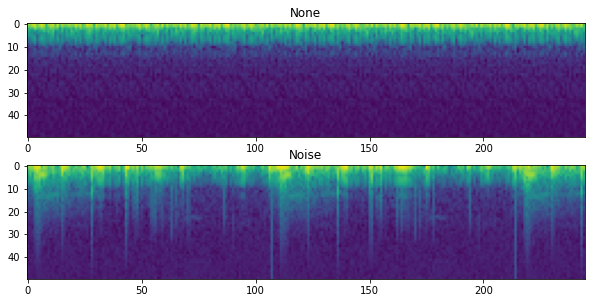

In [ ]:
ind = 4

plt.figure(figsize = (10,10))
plt.subplot(4,1,1)
plt.imshow(training_clips['none'][ind][0].reshape(sample_height, sample_width))
plt.title('None')
plt.subplot(4,1,2)
# plt.imshow(training_clips['noise'][ind][0].reshape(sample_height, sample_width))
plt.imshow(training_clips['both'][ind][0].reshape(sample_height, sample_width))
plt.title('Noise')

### 各種データフレームの読み込み

In [4]:
# patient_data.csv:患者の背景データ
# recording_info.csv:ファイル名を解析したデータ
# recording_anno.csv: ファイル内を解析したデータ
# file_crwh_counts.csv:そのファイルでどれだけcrackling,whistlingが起こったか
patient_data = pd.read_csv("/content/drive/My Drive/grad_article/data_csv/patient_data.csv", index_col=0)
patient_data = patient_data.astype({'Patient number':'uint8'})
recording_info = pd.read_csv("/content/drive/My Drive/grad_article/data_csv/recording_info.csv", index_col=0)
recording_anno = pd.read_csv("/content/drive/My Drive/grad_article/data_csv/recording_anno.csv", index_col=0)
recording_anno = recording_anno.astype({'Start':'float16', 'End':'float16', 'Crackles':'uint8', 'Wheezes':'uint8', 'cr':'uint8', 'wh':'uint8', 'cw':'uint8', 'no':'uint8', 'noise':'uint8'})
file_crwh_counts = pd.read_csv("/content/drive/My Drive/grad_article/data_csv/file_crwh_counts.csv", index_col=0)

In [5]:
# それぞれの音声のみ含むファイル抽出
cr_files = recording_anno[(recording_anno["Crackles"] == 1) & (recording_anno["Wheezes"] == 0)]
wh_files = recording_anno[(recording_anno["Crackles"] == 0) & (recording_anno["Wheezes"] == 1)]
no_files = recording_anno[(recording_anno["Crackles"] == 0) & (recording_anno["Wheezes"] == 0)]
cw_files = recording_anno[(recording_anno["Crackles"] == 1) & (recording_anno["Wheezes"] == 1)]
print(f"{len(cr_files)} {len(wh_files)} {len(no_files)} {len(cw_files)}")

1864 886 3642 506


In [6]:
# new_file.to_csv('/content/drive/My Drive/grad_article/recording_anno.csv')

In [7]:
# recording_anno[recording_anno["Filename"] == "158_2p2_Ar_mc_AKGC417L"]
# new_file = recording_anno.reset_index(drop=True)
# new_file
for i in recording_anno[recording_anno["Filename"] == "226_1b1_Pl_sc_LittC2SE"].index:
  print(type(i))
  break
print(type(recording_anno[recording_anno["Filename"] == "226_1b1_Pl_sc_LittC2SE"].index[0]))

<class 'int'>
<class 'numpy.int64'>


In [8]:
recording_anno[:10]

,Filename,Start,End,Crackles,Wheezes,cr,wh,cw,no,noise
0,101_1b1_Al_sc_Meditron,0.036011,0.579102,0,0,0,0,0,1,0
1,101_1b1_Al_sc_Meditron,0.579102,2.449219,0,0,0,0,0,1,0
2,101_1b1_Al_sc_Meditron,2.449219,3.892578,0,0,0,0,0,1,0
3,101_1b1_Al_sc_Meditron,3.892578,5.792969,0,0,0,0,0,1,0
4,101_1b1_Al_sc_Meditron,5.792969,7.519531,0,0,0,0,0,1,0
5,101_1b1_Al_sc_Meditron,7.519531,9.281250,0,0,0,0,0,1,0
6,101_1b1_Al_sc_Meditron,9.281250,11.148438,0,0,0,0,0,1,0
7,101_1b1_Al_sc_Meditron,11.148438,13.039062,0,0,0,0,0,1,0
8,101_1b1_Al_sc_Meditron,13.039062,14.718750,0,0,0,0,0,1,0
9,101_1b1_Al_sc_Meditron,14.718750,16.703125,0,0,0,0,0,1,0


### 2class to 4class

In [ ]:
class2_dict = joblib.load('/content/drive/MyDrive/grad_article/sample_dicts/sample_dict_2class_rmmargin.dmp')

In [ ]:
def class2_to_class4(class2dict):
  class4dict = class2dict.copy()
  for idx, dicts in enumerate(class4dict):
    crackles = []
    wheezes = []
    both = []
    for e in dicts["noise"]:
      i = e[3]
      if recording_anno.iloc[i]["cr"] == 1:
        crackles.append(e)
      elif recording_anno.iloc[i]["wh"] == 1:
        wheezes.append(e)
      else:
        both.append(e)
    class4dict[idx]["crackles"] = crackles
    class4dict[idx]["wheezes"] = wheezes
    class4dict[idx]["both"] = both
  return class4dict

In [ ]:
class4_dict = class2_to_class4(class2_dict)

In [ ]:
class4_dict[0].keys()

dict_keys(['none', 'noise', 'crackles', 'wheezes', 'both'])

### resp sound listening

In [ ]:
# idx : recording_anno index. ex) idx = test_clips["noise"][0][3] listen_resp(idx) 
def listen_resp(idx):
  filename = recording_anno.iloc[idx]["Filename"]
  start = recording_anno.iloc[idx]["Start"]
  end = recording_anno.iloc[idx]["End"]
  data, sr = 0 , 44100
  data, sr = librosa.load(path + filename + ".wav", sr = sr)
  sidx = int(start * sr)
  eidx = int(end * sr) + 1 
  print(recording_anno.iloc[idx])
  print(f"{data.shape} {start * sr} {end * sr}")
  librosa.display.waveplot(data[sidx : eidx], sr)
  return Audio(data[sidx : eidx],rate=sr, autoplay=True)

Filename    107_3p2_Pl_mc_AKGC417L
Start                      7.85156
End                        10.0547
Crackles                         1
Wheezes                          0
cr                               1
wh                               0
cw                               0
no                               0
noise                            1
Name: 330, dtype: object
(882000,) 346253.90625 443411.71875


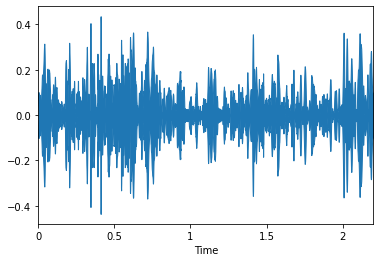

In [ ]:
foo = test_clips["noise"][312][3]
listen_resp(foo)

### to spec image

(144, 216, 3)


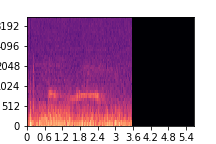

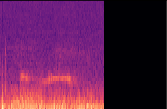

In [ ]:
fig = plt.Figure(figsize=(3, 2))
# fig = plt.Figure() #元々は6,4
canvas = FigureCanvas(fig)
ax = fig.add_subplot(111)
hoge = librosa.display.specshow(training_clips['none'][0][0].reshape(sample_height, sample_width), ax=ax, y_axis='mel', x_axis='s')
buf = io.BytesIO()
fig.savefig(buf, format='png') 
enc = np.frombuffer(buf.getvalue(), dtype=np.uint8) # bufferからの読み出し
hoge = cv2.imdecode(enc, 1)
print(hoge.shape)
cv2_imshow(hoge)
cv2_imshow(hoge[17:-18, 28:-21, :])
# hoge[35:-35, 54:-43, :]

In [ ]:
test_clips['none'][0]

In [ ]:
def to_spec_img(clips):
  '''
    input: each class clip
    output: new class clip
  '''
  for i in range(len(clips)):
    mel_spect = clips[i][0].reshape(sample_height, sample_width)
    fig = plt.Figure(figsize=(3,2)) #指定しないと(6,4) [35:-35, 54:-43, :]
    canvas = FigureCanvas(fig)
    ax = fig.add_subplot(111)
    hoge = librosa.display.specshow(mel_spect[0:,0:], ax = ax, y_axis='mel', x_axis='s', x_coords=np.arange(0, 5, 5./len(mel_spect[0])))
    buf = io.BytesIO()
    fig.savefig(buf, format='png') 
    enc = np.frombuffer(buf.getvalue(), dtype=np.uint8) # bufferからの読み出し
    hoge = cv2.imdecode(enc, 1) #decode
    X = (hoge[17:-18, 28:-21, :] / 255.0).astype(np.float32)
    # print(f'{X.max()} {X.min()} {X.dtype} {X.shape}')
    new_tuple = (X, clips[i][1]) 
    clips[i] = new_tuple

In [ ]:
%%time
test_noise_clips = copy.deepcopy(test_clips['noise'])
to_spec_img(test_noise_clips)

CPU times: user 51.4 s, sys: 558 ms, total: 51.9 s
Wall time: 52 s


In [ ]:
test_noise_clips[33][1]

1

In [ ]:
joblib.dump(test_noise_clips,'/content/drive/MyDrive/grad_article/img_dicts/test_noise_img_dict2.dmp', compress=3)

['/content/drive/MyDrive/grad_article/img_dicts/test_noise_img_dict2.dmp']

In [ ]:
load_sample = joblib.load('/content/drive/MyDrive/grad_article/img_dicts/test_none_img_dict2.dmp')

In [ ]:
load_sample[0]

(array([[[0.03921569, 0.00784314, 0.01176471],
         [0.04705882, 0.01176471, 0.01960784],
         [0.03921569, 0.00784314, 0.01176471],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.07450981, 0.07450981, 0.07450981]],
 
        [[0.20392157, 0.05098039, 0.07450981],
         [0.24705882, 0.0627451 , 0.09803922],
         [0.20392157, 0.05098039, 0.07450981],
         ...,
         [0.01568628, 0.        , 0.        ],
         [0.01568628, 0.        , 0.        ],
         [0.2       , 0.2       , 0.2       ]],
 
        [[0.1764706 , 0.04313726, 0.0627451 ],
         [0.28627452, 0.06666667, 0.11764706],
         [0.23921569, 0.05882353, 0.09411765],
         ...,
         [0.01568628, 0.        , 0.        ],
         [0.01568628, 0.        , 0.        ],
         [0.2       , 0.2       , 0.2       ]],
 
        ...,
 
        [[0.47058824, 0.6901961 , 0.99607843],
         [0.6392157 , 0.8862745 , 0.99215

### 雑多な作業用

pinfoにおいてBMIを取得したい \\
方針：本来は身長と体重をデータとして取り込みたかったが、今回は成人の身長体重がBMIとしか記録されていないので、BMIを与える。 \\
身長体重がNanのデータには、年齢での平均を与えようか \\
と思ったけど、肥満の尺度が年齢でだいぶ違うので、（ローレル指数とか）それぞれの尺度を大人用のBMIの範囲に落とし込みたい。

In [ ]:
# 1inch -> 2.54cm
# 1cm -> 0.39inch
# 1lbs(pond) -> 0.453592kg
# 1kg -> 2.22 libs 
98.50 * 0.39

38.415

In [ ]:
child = patient_data.drop(patient_data.index[121]) # drop age 60
child = child[child['Adult BMI (kg/m2)'].isnull()]

# age1 = child[child['Age'] == 1.00]
# age1.describe()
# age1.fillna({'Child Height (cm)':80.1})

# age3 = child[child['Age'] == 3.00]
# age3.describe()
# age3.fillna({'Child Weight (kg)': 16.1 , 'Child Height (cm)':98.5})

# age12 = child[child['Age'] >= 11.00] # wavファイル少ないし、Noだし手間の無駄
# age12 #13歳と11歳の平均を入れとく
# age12.fillna({'Child Weight (kg)': 49.0 , 'Child Height (cm)':153})

# age14 = child[child['Age'] == 14.00]
# age14.describe()
# age14.fillna({'Child Weight (kg)': 71.0 , 'Child Height (cm)':176.5})

# age16 = child[child['Age'] == 16.00] # wavファイル少ない.異音は多少含まれてる
# age16.describe()
# age16.fillna({'Child Weight (kg)': 70.0 , 'Child Height (cm)':183.0})

In [ ]:
child = patient_data.drop(patient_data.index[121]) # drop age 60
df = patient_data
child = child[child['Adult BMI (kg/m2)'].isnull()]
age1 = child[child['Age'] == 1.00].fillna({'Child Height (cm)':80.1})
age3 = child[child['Age'] == 3.00].fillna({'Child Weight (kg)': 16.1 , 'Child Height (cm)':98.5})
age12 = child[child['Age'] == 12.00].fillna({'Child Weight (kg)': 49.0 , 'Child Height (cm)':153.0})
age14 = child[child['Age'] == 14.00].fillna({'Child Weight (kg)': 71.0 , 'Child Height (cm)':176.5})
age16 = child[child['Age'] == 16.00].fillna({'Child Weight (kg)': 70.0 , 'Child Height (cm)':183.0})
for_NaN = df[df['Age'] >= 20.00].fillna({'Age': 69.0 , 'Adult BMI (kg/m2)':27.4})

In [ ]:
patient_data[patient_data['Age'] == 1.00] = age1
patient_data[patient_data['Age'] == 3.00] = age3
patient_data[patient_data['Age'] == 12.00] = age12
patient_data[patient_data['Age'] == 14.00] = age14
patient_data[patient_data['Age'] == 16.00] = age16
patient_data[patient_data['Age'] >= 20.00] = for_NaN
# patient_data.iloc[122].fillna({'Sex': 'M', 'Age': 69.0 , 'Adult BMI (kg/m2)':27.4}, inplace=True)
patient_data.loc[122, 'Age'] = 69.0
patient_data.loc[122, 'Sex'] = 'M'
patient_data.loc[122, 'Adult BMI (kg/m2)'] = 27.4

In [ ]:
patient_data.describe()

,Patient number,Age,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm)
count,126.000000,126.000000,126.000000,49.000000,49.000000
mean,163.500000,43.199048,23.484117,23.716122,107.826531
std,36.517119,32.163534,6.505943,19.378813,33.146611
min,101.000000,0.250000,13.119534,7.140000,64.000000
25%,132.250000,4.250000,17.463305,12.000000,85.000000
50%,163.500000,60.500000,23.060000,16.100000,99.000000
75%,194.750000,70.750000,28.250000,30.000000,119.000000
max,226.000000,93.000000,53.500000,80.000000,183.000000


In [ ]:
child_data = patient_data[patient_data['Age'] < 19]
kg = child_data['Child Weight (kg)']
cm = child_data['Child Height (cm)']
bmi = kg / (cm/100) ** 2
idx, bmil = bmi.index, bmi.to_list()
for i, e in enumerate(idx):
   patient_data.loc[e, 'Adult BMI (kg/m2)'] = bmil[i]
patient_data

,Patient number,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm),Diagnosis
0,101,3.00,F,19.385777,19.0,99.0,URTI
1,102,0.75,F,18.389942,9.8,73.0,Healthy
2,103,70.00,F,33.000000,NaN,NaN,Asthma
3,104,70.00,F,28.470000,NaN,NaN,COPD
4,105,7.00,F,17.558299,32.0,135.0,URTI
...,...,...,...,...,...,...,...
121,222,60.00,M,27.400000,NaN,NaN,COPD
122,223,69.00,M,27.400000,NaN,NaN,COPD
123,224,10.00,F,15.795393,32.3,143.0,Healthy
124,225,0.83,M,14.243974,7.8,74.0,Healthy


In [ ]:
child_data = patient_data[patient_data['Age'] < 19]
kg = child_data['Child Weight (kg)']
cm = child_data['Child Height (cm)']
a = kg / (cm/100) ** 2
print(a.index)
a = a.to_list()
child_bmi = [int(i) for i in a]

Int64Index([  0,   1,   4,   7,  14,  18,  20,  22,  24,  25,  26,  28,  30,
             35,  36,  42,  43,  47,  48,  49,  51,  52,  58,  60,  63,  64,
             66,  70,  72,  78,  81,  82,  83,  86,  87,  89,  93,  96, 101,
            105, 107, 108, 109, 113, 115, 116, 123, 124, 125],
           dtype='int64')


In [ ]:
under_5 =  patient_data[patient_data['Age'] <= 5]
kg = under_5['Child Weight (kg)']
cm = under_5['Child Height (cm)']
a = kg / (cm/100) ** 2
a = a.to_list()
u5_bmi = [int(i) for i in a]

In [ ]:
over_5 =  child_data[child_data['Age'] > 5]
kg = over_5['Child Weight (kg)']
cm = over_5['Child Height (cm)']
a = kg / (cm/100) ** 2
a = a.to_list()
o5_bmi = [int(i) for i in a]

In [ ]:
plt.hist(o5_bmi, bins = 10, range = (min(child_bmi), 53))
over_5['Age']

In [ ]:
plt.hist(u5_bmi, bins = 10, range = (min(child_bmi), 53))
under_5['Age']

In [ ]:
plt.hist(child_bmi, bins = 10, range = (min(child_bmi), 53))

In [ ]:
adult_bmi = patient_data['Adult BMI (kg/m2)'].dropna()
adult_bmi = [int(i) for i in adult_bmi]
plt.hist(adult_bmi, bins = 10, range = (min(child_bmi), 53))

In [ ]:
foo_path = '/content/drive/MyDrive/grad_article/respiratory-sound-database/Respiratory_Sound_Database/audio_and_txt_files'
%ls '/content/drive/MyDrive/grad_article/respiratory-sound-database/Respiratory_Sound_Database/audio_and_txt_files'

In [ ]:
recording_anno[6778:6820] #223

## **2class with patient**

### data preprocess 

In [ ]:
patient_data = pd.read_csv("/content/drive/My Drive/grad_article/data_csv/patient_data.csv", index_col=0)
patient_data = patient_data.astype({'Patient number':'uint8'})

NameError: ignored

In [ ]:
# pid = training_clips['noise'][0][2]
# patient_data[patient_data['Patient number'] == pid]

# patient_data[patient_data['Sex'].isnull()]
# patient_data[patient_data['Age'].isnull()]
# patient_data[patient_data['Patient number'] == 122]
'''
P_ID
Age,Sex is null = 223
BMI, Weight Height is numm = 108,183,190,197,217,222,223 

Sex 
F:46
M:79
nan:1

223 sex->F, Age->43.0
'''
# patient_data[(patient_data['Adult BMI (kg/m2)'].isnull()) & (patient_data['Child Weight (kg)'].isnull()) & (patient_data['Child Height (cm)'].isnull())]

In [ ]:
# patient_data[patient_data['Patient number'] == 223]['Sex'] = 43.0
patient_data.loc[122, 'Age'] = 43.0

In [ ]:
patient_data['Sex'] = patient_data['Sex'].apply(lambda x: 1 if x == "M" else 0)

In [ ]:
patient_data['Age'] /= patient_data['Age'].max()

In [ ]:
patient_data = patient_data.astype({'Sex':'int8'})

In [ ]:
patient_data.describe()

In [ ]:
pid = training_clips['noise'][0][2]
patient_data[patient_data['Patient number'] == pid][['Sex', 'Age']].values

### Data Pipeline

In [ ]:
import scipy.signal

#Interleaved sampling between classes
#Used to ensure a balance of classes for the training set
class data_generator():
    #sound_clips = [[none],[crackles],[wheezes],[both]]
    #strides: How far the sampling index for each category is advanced for each step
    def __init__(self, sound_clips, strides, p_info):
        self.clips = sound_clips
        self.strides = strides
        self.lengths = [len(arr) for arr in sound_clips]
        self.p_info = p_info
    
    def n_available_samples(self):
        return int(min(np.divide(self.lengths, self.strides))) * 2#
    
    def generate_keras(self, batch_size):
        cursor = [0, 0] #
        while True:
            i = 0
            X1, X2, y = [],[],[]
            for _ in range(batch_size):
                cat_length = self.lengths[i]
                cat_clips = self.clips[i]
                cat_stride = self.strides[i]
                cat_advance = np.random.randint(low= 1,high = cat_stride + 1)
                clip = cat_clips[(cursor[i] + cat_advance) % cat_length]
                cursor[i] = (cursor[i] + self.strides[i]) % cat_length #advance cursor
                s = (self.rollFFT(clip))
                X1.append(s[0])
                y.append(s[1])
                p_id = clip[2]
                info = self.p_info[self.p_info['Patient number'] == p_id][['Sex', 'Age']].values
                X2.append(info)
                i = (i + 1) % 2 # go to next class
            yield ([np.reshape(X1, (batch_size, sample_height, sample_width, 1)) ,np.reshape(X2, (batch_size, 2))],
            np.reshape(y,(batch_size,1)))

    #Transpose and wrap each array along the time axis
    def rollFFT(self, fft_info):
        fft = fft_info[0]
        n_col = fft.shape[1]
        pivot = np.random.randint(n_col)
        return ((np.roll(fft, pivot, axis = 1)), fft_info[1])

#Used for validation set
class feed_all():
    #sound_clips = [[none],[crackles],[wheezes],[both]]
    #strides: How far the sampling index for each category is advanced for each step
    def __init__(self, sound_clips, p_info, roll = True):
        merged = []
        for arr in sound_clips:
            merged.extend(arr)
        np.random.shuffle(merged)
        self.clips = merged
        self.nclips = len(merged)
        self.roll = roll
        self.p_info = p_info
    
    def n_available_samples(self):
        return len(self.clips)
    
    def generate_keras(self, batch_size):
        i = 0
        while True:
            X1,X2,y = [],[],[]
            for b in range(batch_size):
                clip = self.clips[i]
                i = (i + 1) % self.nclips
                if(self.roll):
                    s = (self.rollFFT(clip))
                    X1.append(s[0])
                    y.append(s[1])
                    p_id = clip[2]
                    info = self.p_info[self.p_info['Patient number'] == p_id][['Sex', 'Age']].values
                    X2.append(info)
                else:
                    X1.append(clip[0])
                    y.append(clip[1])
                    p_id = clip[2]
                    info = self.p_info[self.p_info['Patient number'] == p_id][['Sex', 'Age']].values
                    X2.append(info)
                    
            yield ([np.reshape(X1, (batch_size,sample_height, sample_width,1)), np.reshape(X2, (batch_size, 2))],
            np.reshape(y,(batch_size, 1)))

    #Transpose and wrap each array along the time axis
    def rollFFT(self, fft_info):
        fft = fft_info[0]
        n_col = fft.shape[1]
        pivot = np.random.randint(n_col)
        return ((np.roll(fft, pivot, axis = 1)), fft_info[1])

In [ ]:
training_clips = sample_dict[0]
test_clips = sample_dict[1]
[none_train, noise_train] = [training_clips['none'], training_clips['noise']]
[none_test, noise_test] =  [test_clips['none'], test_clips['noise']]

np.random.shuffle(none_train)
np.random.shuffle(noise_train)

#Data pipeline objects
train_gen = data_generator([none_train, noise_train], [1,1], patient_data)
test_gen = feed_all([none_test, noise_test], patient_data)

KeyError: ignored

In [ ]:
# train_gen.generate_keras(32).__next__()

### CNN implementation

In [ ]:
import keras.layers as layers
from keras import optimizers
from keras import backend as K
K.clear_session()

spect_input = keras.Input(shape=(sample_height, sample_width, 1), name="spec")
pinfo_input = keras.Input(shape=(2,), name="pinfo")

pinfo_features = layers.Dense(128, activation = 'relu')(pinfo_input)
pinfo_features = layers.Dense(128, activation = 'relu')(pinfo_features)
pinfo_features = layers.Dropout(0.5)(pinfo_features)
pinfo_features = layers.Dense(64, activation = 'relu')(pinfo_features)
'''
spect
'''

spect_features = layers.Conv2D(128, [7,11], strides = [2,2], padding = 'SAME')(spect_input)
spect_features = layers.LeakyReLU(alpha = 0.1)(spect_features)
spect_features = layers.MaxPool2D(padding = 'SAME')(spect_features)

spect_features = layers.Conv2D(256, [5,5], padding = 'SAME')(spect_features)
spect_features = layers.LeakyReLU(alpha = 0.1)(spect_features)
spect_features = layers.MaxPool2D(padding = 'SAME')(spect_features)
spect_features = layers.Dropout(0.5)(spect_features)

spect_features = layers.Conv2D(256, [1,1], padding = 'SAME')(spect_features)
spect_features = layers.Conv2D(256, [3,3], padding = 'SAME')(spect_features)
spect_features = layers.LeakyReLU(alpha = 0.1)(spect_features)
spect_features = layers.MaxPool2D(padding = 'SAME')(spect_features)
spect_features = layers.Dropout(0.5)(spect_features)

spect_features = layers.Conv2D(512, [1,1], padding = 'SAME')(spect_features)
spect_features = layers.Conv2D(512, [3,3], padding = 'SAME', activation = 'relu')(spect_features)
spect_features = layers.Conv2D(512, [1,1], padding = 'SAME')(spect_features)
spect_features = layers.Conv2D(512, [3,3], padding = 'SAME', activation = 'relu')(spect_features)
spect_features = layers.MaxPool2D(padding = 'SAME')(spect_features)

# 2*8*512
# spect_features = tf.reshape(spect_features, [-1, 16, 512])
# spect_features = layers.LSTM(256, return_sequences=True)(spect_features)
# spect_features = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(spect_features)

spect_features = layers.Flatten()(spect_features)
spect_features = layers.Dense(4096, activation='relu')(spect_features)
spect_features = layers.Dropout(0.5)(spect_features)
spect_features = layers.Dense(512, activation='relu')(spect_features)


x = layers.concatenate([spect_features, pinfo_features])
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs = [spect_input, pinfo_input],
                    outputs = outputs)

opt = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)
model.compile(optimizer =  opt , loss = 'binary_crossentropy', metrics = ['acc'])


In [ ]:
keras.utils.plot_model(model, "mini_resnet.png", show_shapes=True)

KeyboardInterrupt: ignored

In [ ]:
batch_size = 64
n_epochs = 30
stats = model.fit(train_gen.generate_keras(batch_size), 
                            steps_per_epoch = train_gen.n_available_samples() // batch_size,
                            validation_data = test_gen.generate_keras(batch_size),
                            validation_steps = test_gen.n_available_samples() // batch_size, 
                            epochs = n_epochs)

In [ ]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(stats.history['acc'], label = 'training acc')
plt.plot(stats.history['val_acc'], label = 'validation acc')
plt.legend()
plt.subplot(1,2,2)
plt.plot(stats.history['loss'], label = 'training loss')
plt.plot(stats.history['val_loss'], label = 'validation loss')
plt.legend()
plt.title('Loss')

In [ ]:
fname = "0103_2303_model"
model.save('/content/drive/MyDrive/grad_article/models/' + fname)

In [ ]:
test_set = test_gen.generate_keras(test_gen.n_available_samples()).__next__()
pred = model.predict(test_set[0])
predictions =  np.where(pred > 0.5, 1, 0)
labels = np.argmax(test_set[1], axis = 1)

In [ ]:
len(predictions[test_set[1] == predictions]) / len(predictions)

In [ ]:
# 間違えたインデックス
idx = np.array([i for i in range(len(predictions))])
hoge = test_set[1] != predictions
hoge = np.reshape(hoge, len(predictions))
f_idx = idx[hoge]

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

y_test = np.reshape(test_set[1], len(test_set[1]))
y_pred = np.reshape(predictions, len(test_set[1]))
cm = confusion_matrix(y_test, y_pred)
'''
TN FP
FN TP
'''
print(cm)

print(f1_score(y_test, y_pred))

print(precision_score(y_test, y_pred))

print(recall_score(y_test, y_pred))

###gradcam

In [ ]:
# 画像用
from keras.preprocessing.image import array_to_img, img_to_array, load_img

# Grad−CAM計算用
from tensorflow.keras import models
IMAGE_SIZE=(sample_width, sample_height)# xy が逆

In [ ]:
def grad_cam(input_model, x, info, layer_name):
    """
    Args: 
        input_model(object): モデルオブジェクト
        x(ndarray): 画像
        layer_name(string): 畳み込み層の名前
    Returns:
        output_image(ndarray): 元の画像に色付けした画像
    """

    # 画像の前処理
    # 読み込む画像が1枚なため、次元を増やしておかないとmode.predictが出来ない
    X = np.expand_dims(x, axis=0)
    # preprocessed_input = X.astype('float32') / 255.0    

    grad_model = models.Model([input_model.inputs], [input_model.get_layer(layer_name).output, input_model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model((X,info))
        class_idx = np.argmax(predictions[0])
        print(f"predict {class_idx}")
        loss = predictions[:, class_idx]

    # 勾配を計算
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')

    all_grads = gate_f * gate_r * grads

    # 重みを平均化して、レイヤーの出力に乗じる
    weights = np.mean(all_grads, axis=(0, 1))
    cam = np.dot(output, weights)

    # 画像を元画像と同じ大きさにスケーリング
    cam = cv2.resize(cam, IMAGE_SIZE, cv2.INTER_LINEAR)
    # ReLUの代わり
    cam  = np.maximum(cam, 0)
    # ヒートマップを計算
    heatmap = cam / cam.max()

    # モノクロ画像に疑似的に色をつける
    jet_cam = cv2.applyColorMap(np.uint8(255.0*heatmap), cv2.COLORMAP_JET)
    # RGBに変換
    rgb_cam = cv2.cvtColor(jet_cam, cv2.COLOR_BGR2RGB)
    # もとの画像に合成
    output_image = (np.float32(rgb_cam) + x / 2)  

    return output_image

In [ ]:
x = none_test[0][0]
cv2_imshow(x * 255.0)
print(x.shape)
print(none_test[0][2])
# IMAGE_SIZE

In [ ]:
fname = "0103_2303_model"
model = keras.models.load_model('/content/drive/MyDrive/grad_article/models/' + fname)

In [ ]:
model.summary()

In [ ]:
target_layer = 'conv2d_5'
p_id = none_test[0][2]
info = patient_data[patient_data['Patient number'] == p_id][['Sex', 'Age']].values
cam = grad_cam(model, x, info, target_layer)
array_to_img(cam)

## **4class with patient**

### data preprocess 

↓**child BMI導入**

In [9]:
patient_data = pd.read_csv("/content/drive/My Drive/grad_article/data_csv/patient_data.csv", index_col=0)
patient_data = patient_data.astype({'Patient number':'uint8'})

In [10]:
child = patient_data.drop(patient_data.index[121]) # drop age 60
df = patient_data
child = child[child['Adult BMI (kg/m2)'].isnull()]
age1 = child[child['Age'] == 1.00].fillna({'Child Height (cm)':80.1})
age3 = child[child['Age'] == 3.00].fillna({'Child Weight (kg)': 16.1 , 'Child Height (cm)':98.5})
age12 = child[child['Age'] == 12.00].fillna({'Child Weight (kg)': 49.0 , 'Child Height (cm)':153.0})
age14 = child[child['Age'] == 14.00].fillna({'Child Weight (kg)': 71.0 , 'Child Height (cm)':176.5})
age16 = child[child['Age'] == 16.00].fillna({'Child Weight (kg)': 70.0 , 'Child Height (cm)':183.0})
for_NaN = df[df['Age'] >= 20.00].fillna({'Age': 69.0 , 'Adult BMI (kg/m2)':27.4})

In [11]:
patient_data[patient_data['Age'] == 1.00] = age1
patient_data[patient_data['Age'] == 3.00] = age3
patient_data[patient_data['Age'] == 12.00] = age12
patient_data[patient_data['Age'] == 14.00] = age14
patient_data[patient_data['Age'] == 16.00] = age16
patient_data[patient_data['Age'] >= 20.00] = for_NaN
# patient_data.iloc[122].fillna({'Sex': 'M', 'Age': 69.0 , 'Adult BMI (kg/m2)':27.4}, inplace=True)
patient_data.loc[122, 'Age'] = 69.0
patient_data.loc[122, 'Sex'] = 'M'
patient_data.loc[122, 'Adult BMI (kg/m2)'] = 27.4

In [12]:
child_data = patient_data[patient_data['Age'] < 19]
kg = child_data['Child Weight (kg)']
cm = child_data['Child Height (cm)']
bmi = kg / (cm/100) ** 2
idx, bmil = bmi.index, bmi.to_list()
for i, e in enumerate(idx):
   patient_data.loc[e, 'Adult BMI (kg/m2)'] = bmil[i]

In [13]:
patient_data.describe()

,Patient number,Age,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm)
count,126.000000,126.000000,126.000000,49.000000,49.000000
mean,163.500000,43.199048,23.484117,23.716122,107.826531
std,36.517119,32.163534,6.505943,19.378813,33.146611
min,101.000000,0.250000,13.119534,7.140000,64.000000
25%,132.250000,4.250000,17.463305,12.000000,85.000000
50%,163.500000,60.500000,23.060000,16.100000,99.000000
75%,194.750000,70.750000,28.250000,30.000000,119.000000
max,226.000000,93.000000,53.500000,80.000000,183.000000


In [14]:
patient_data['Adult BMI (kg/m2)'] = (patient_data['Adult BMI (kg/m2)'] - patient_data['Adult BMI (kg/m2)'].min()) / patient_data['Adult BMI (kg/m2)'].std()
patient_data.describe()

,Patient number,Age,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm)
count,126.000000,126.000000,126.000000,49.000000,49.000000
mean,163.500000,43.199048,1.593095,23.716122,107.826531
std,36.517119,32.163534,1.000000,19.378813,33.146611
min,101.000000,0.250000,0.000000,7.140000,64.000000
25%,132.250000,4.250000,0.667662,12.000000,85.000000
50%,163.500000,60.500000,1.527905,16.100000,99.000000
75%,194.750000,70.750000,2.325638,30.000000,119.000000
max,226.000000,93.000000,6.206704,80.000000,183.000000


↓**Age Sex 標準化**

In [15]:
# pid = training_clips['noise'][0][2]
# patient_data[patient_data['Patient number'] == pid]

# patient_data[patient_data['Sex'].isnull()]
# patient_data[patient_data['Age'].isnull()]
# patient_data[patient_data['Patient number'] == 122]
'''
P_ID
Age,Sex is null = 223
BMI, Weight Height is null = 108,183,190,197,217,222,223 

Sex 
F:46
M:79
nan:1

223 sex->F, Age->43.0
'''
# patient_data[(patient_data['Adult BMI (kg/m2)'].isnull()) & (patient_data['Child Weight (kg)'].isnull()) & (patient_data['Child Height (cm)'].isnull())]

'\nP_ID\nAge,Sex is null = 223\nBMI, Weight Height is null = 108,183,190,197,217,222,223 \n\nSex \nF:46\nM:79\nnan:1\n\n223 sex->F, Age->43.0\n'

In [16]:
# patient_data.loc[122, 'Age'] = 43.0

In [17]:
# patient_data['Sex'] = patient_data['Sex'].apply(lambda x: 1 if x == "M" else 0)

In [18]:
# patient_data['Age'] /= patient_data['Age'].max()

In [19]:
# patient_data = patient_data.astype({'Sex':'int8'})

In [20]:
# patient_data.describe()

### data check

In [ ]:
def class2_to_class4(class2dict):
  class4dict = class2dict.copy()
  for idx, dicts in enumerate(class4dict):
    crackles = []
    wheezes = []
    both = []
    for e in dicts["noise"]:
      i = e[3]
      if recording_anno.iloc[i]["cr"] == 1:
        crackles.append(e)
      elif recording_anno.iloc[i]["wh"] == 1:
        wheezes.append(e)
      else:
        both.append(e)
    class4dict[idx]["crackles"] = crackles
    class4dict[idx]["wheezes"] = wheezes
    class4dict[idx]["both"] = both
  return class4dict
# 2->4だとデータ数が不均衡だから微妙

In [ ]:
def print_sample_count(src_dict):
    print(f"none:{len(src_dict['none'])}\ncrackles:{len(src_dict['crackles'])}\
    \nwheezes:{len(src_dict['wheezes'])}\nboth:{len(src_dict['both'])}")

# sample_dict = class2_to_class4(sample_dict)
training_clips = sample_dict[0]
test_clips = sample_dict[1]
print('Samples Available')
print('[Training set]')
print_sample_count(training_clips)
print('')
print('[Test set]')
print_sample_count(test_clips)

Samples Available
[Training set]
none:6086
crackles:6048    
wheezes:7280
both:6800

[Test set]
none:760
crackles:376    
wheezes:183
both:108


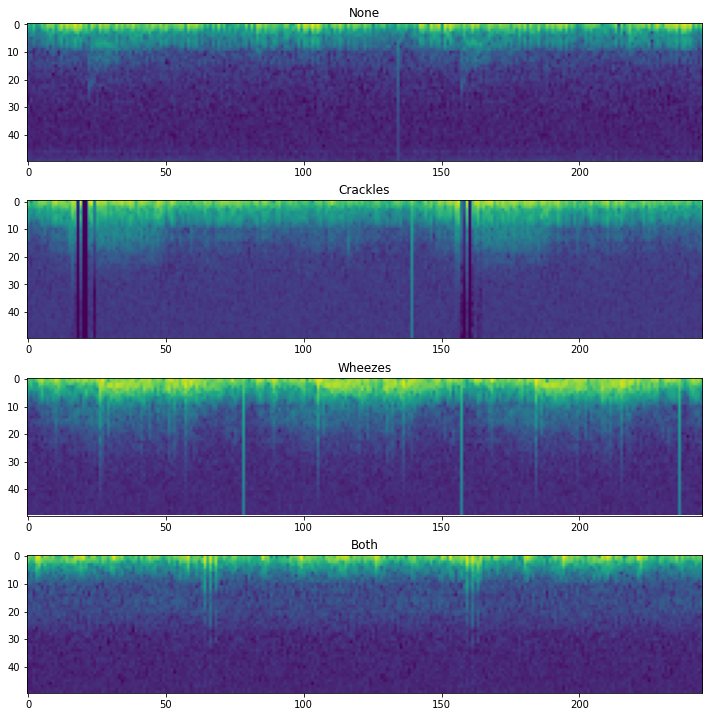

In [ ]:
#Example of tiled sound samples

sample_height = training_clips['none'][0][0].shape[0]
sample_width = training_clips['none'][0][0].shape[1]

ind = 10
plt.figure(figsize = (10,10))
plt.subplot(4,1,1)
plt.imshow(training_clips['none'][ind][0].reshape(sample_height, sample_width))
plt.title('None')
plt.subplot(4,1,2)
plt.imshow(training_clips['crackles'][ind][0].reshape(sample_height, sample_width))
plt.title('Crackles')
plt.subplot(4,1,3)
plt.imshow(training_clips['wheezes'][ind][0].reshape(sample_height, sample_width))
plt.title('Wheezes')
plt.subplot(4,1,4)
plt.imshow(training_clips['both'][ind][0].reshape(sample_height, sample_width))
plt.title('Both')
plt.tight_layout()

### Data Pipeline

In [21]:
# p_info = patient_data
# p_info[p_info['Patient number'] == 101][['Adult BMI (kg/m2)']].values

In [22]:
import scipy.signal

#Interleaved sampling between classes
#Used to ensure a balance of classes for the training set
class data_generator():
    #sound_clips = [[none],[crackles],[wheezes],[both]]
    #strides: How far the sampling index for each category is advanced for each step
    def __init__(self, sound_clips, strides, p_info):
        self.clips = sound_clips
        self.strides = strides
        self.lengths = [len(arr) for arr in sound_clips]
        self.p_info = p_info
        
    def n_available_samples(self):
        return int(min(np.divide(self.lengths, self.strides))) * 4
    
    def generate_keras(self, batch_size):
        cursor = [0,0,0,0]
        while True:
            i = 0
            X1, X2, y = [],[],[]
            for _ in range(batch_size):
                cat_length = self.lengths[i]
                cat_clips = self.clips[i]
                cat_stride = self.strides[i]
                cat_advance = np.random.randint(low= 1,high = cat_stride + 1)
                clip = cat_clips[(cursor[i] + cat_advance) % cat_length]
                cursor[i] = (cursor[i] + self.strides[i]) % cat_length #advance cursor
                s = (self.rollFFT(clip))
                X1.append(s[0])
                y.append(s[1])
                p_id = clip[2]
                # info = self.p_info[self.p_info['Patient number'] == p_id][['Sex', 'Age']].values
                info = self.p_info[self.p_info['Patient number'] == p_id][['Adult BMI (kg/m2)']].values
                X2.append(info)
                i = (i + 1) % 4 # go to next class
            # yield ([np.reshape(X1, (batch_size, sample_height, sample_width, 1)) ,np.reshape(X2, (batch_size, 2))],
            #        np.reshape(y,(batch_size,4)))
            yield ([np.reshape(X1, (batch_size, sample_height, sample_width, 1)) ,np.reshape(X2, (batch_size, 1))],
                   np.reshape(y,(batch_size,4)))

    #Transpose and wrap each array along the time axis
    def rollFFT(self, fft_info):
        fft = fft_info[0]
        n_col = fft.shape[1]
        pivot = np.random.randint(n_col)
        return ((np.roll(fft, pivot, axis = 1)), fft_info[1])

#Used for validation set
class feed_all():
    #sound_clips = [[none],[crackles],[wheezes],[both]]
    #strides: How far the sampling index for each category is advanced for each step
    def __init__(self, sound_clips, p_info, roll = True):
        merged = []
        for arr in sound_clips:
            merged.extend(arr)
        np.random.shuffle(merged)
        self.clips = merged
        self.nclips = len(merged)
        self.roll = roll
        self.p_info = p_info
    
    def n_available_samples(self):
        return len(self.clips)
    
    def generate_keras(self, batch_size):
        i = 0
        while True:
            X1, X2, y = [],[],[]
            for b in range(batch_size):
                clip = self.clips[i]
                i = (i + 1) % self.nclips
                if (self.roll):
                    s = (self.rollFFT(clip))
                    X1.append(s[0])
                    y.append(s[1])
                    p_id = clip[2]
                    # info = self.p_info[self.p_info['Patient number'] == p_id][['Sex', 'Age']].values
                    info = self.p_info[self.p_info['Patient number'] == p_id][['Adult BMI (kg/m2)']].values
                    X2.append(info)
                else:
                    X1.append(clip[0])
                    y.append(clip[1])
                    p_id = clip[2]
                    # info = self.p_info[self.p_info['Patient number'] == p_id][['Sex', 'Age']].values
                    info = self.p_info[self.p_info['Patient number'] == p_id][['Adult BMI (kg/m2)']].values
                    X2.append(info)
            # yield ([np.reshape(X1, (batch_size,sample_height, sample_width,1)), np.reshape(X2, (batch_size, 2))],
            #       np.reshape(y,(batch_size, 4)))
            yield ([np.reshape(X1, (batch_size,sample_height, sample_width,1)), np.reshape(X2, (batch_size, 1))],
                  np.reshape(y,(batch_size, 4)))

    #Transpose and wrap each array along the time axis
    def rollFFT(self, fft_info):
        fft = fft_info[0]
        n_col = fft.shape[1]
        pivot = np.random.randint(n_col)
        return ((np.roll(fft, pivot, axis = 1)), fft_info[1])

In [25]:
from sklearn.model_selection import train_test_split

[none_train, c_train, w_train, cw_train] = [training_clips['none'], training_clips['crackles'], training_clips['wheezes'], training_clips['both']]
[none_test, c_test, w_test,cw_test] =  [test_clips['none'], test_clips['crackles'], test_clips['wheezes'], test_clips['both']]

none_train, none_val = train_test_split(none_train, test_size=0.1, random_state=5)
c_train, c_val = train_test_split(c_train, test_size=0.1, random_state=5)
w_train, w_val = train_test_split(w_train, test_size=0.1, random_state=5)
cw_train, cw_val = train_test_split(cw_train, test_size=0.1, random_state=5)

#Data pipeline objects
train_gen = data_generator([none_train, c_train, w_train, cw_train], [1,1,1,1], patient_data)
val_gen = feed_all([none_val, c_val, w_val, cw_val], patient_data, False)
test_gen = feed_all([none_test, c_test, w_test, cw_test], patient_data, False)

### CNN implementation

In [ ]:
import keras.layers as layers
from keras import optimizers
from keras import backend as K
K.clear_session()

spect_input = keras.Input(shape=(sample_height, sample_width, 1), name="spec")
pinfo_input = keras.Input(shape=(2,), name="pinfo")

pinfo_features = layers.Dense(128, activation = 'relu')(pinfo_input)
pinfo_features = layers.Dense(128, activation = 'relu')(pinfo_features)
pinfo_features = layers.Dropout(0.5)(pinfo_features)
pinfo_features = layers.Dense(64, activation = 'relu')(pinfo_features)
'''
spect
'''

spect_features = layers.Conv2D(128, [7,11], strides = [2,2], padding = 'SAME')(spect_input)
spect_features = layers.LeakyReLU(alpha = 0.1)(spect_features)
spect_features = layers.MaxPool2D(padding = 'SAME')(spect_features)

spect_features = layers.Conv2D(256, [5,5], padding = 'SAME')(spect_features)
spect_features = layers.LeakyReLU(alpha = 0.1)(spect_features)
spect_features = layers.MaxPool2D(padding = 'SAME')(spect_features)
spect_features = layers.Dropout(0.5)(spect_features)

spect_features = layers.Conv2D(256, [1,1], padding = 'SAME')(spect_features)
spect_features = layers.Conv2D(256, [3,3], padding = 'SAME')(spect_features)
spect_features = layers.LeakyReLU(alpha = 0.1)(spect_features)
spect_features = layers.MaxPool2D(padding = 'SAME')(spect_features)
spect_features = layers.Dropout(0.5)(spect_features)

spect_features = layers.Conv2D(512, [1,1], padding = 'SAME')(spect_features)
spect_features = layers.Conv2D(512, [3,3], padding = 'SAME', activation = 'relu')(spect_features)
spect_features = layers.Conv2D(512, [1,1], padding = 'SAME')(spect_features)
spect_features = layers.Conv2D(512, [3,3], padding = 'SAME', activation = 'relu')(spect_features)
spect_features = layers.MaxPool2D(padding = 'SAME')(spect_features)

# 2*8*512
# spect_features = tf.reshape(spect_features, [-1, 16, 512])
# spect_features = layers.LSTM(256, return_sequences=True)(spect_features)
# spect_features = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(spect_features)

spect_features = layers.Flatten()(spect_features)
spect_features = layers.Dense(4096, activation='relu')(spect_features)
spect_features = layers.Dropout(0.5)(spect_features)
spect_features = layers.Dense(512, activation='relu')(spect_features)


x = layers.concatenate([spect_features, pinfo_features])
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(4, activation='softmax')(x)

model = keras.Model(inputs = [spect_input, pinfo_input],
                    outputs = outputs)

opt = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)
model.compile(optimizer =  opt , loss = 'categorical_crossentropy', metrics = ['acc'])

### new_model

In [47]:
import keras.layers as layers
from keras import optimizers
from keras import backend as K
K.clear_session()

spect_input = keras.Input(shape=(sample_height, sample_width, 1), name="spec")
# pinfo_input = keras.Input(shape=(2,), name="pinfo")
pinfo_input = keras.Input(shape=(1,), name="pinfo")

pinfo_features = layers.Dense(256, activation = 'relu')(pinfo_input)
pinfo_features = layers.Dense(256, activation = 'relu')(pinfo_features)
pinfo_features = layers.Dense(128, activation = 'relu')(pinfo_input)
pinfo_features = layers.Dense(128, activation = 'relu')(pinfo_features)
# pinfo_features = layers.Dropout(0.5)(pinfo_features)
pinfo_features = layers.Dense(64, activation = 'relu')(pinfo_features)

'''
spect
'''
import keras.layers as layers
from keras import optimizers
from keras import backend as K
K.clear_session()

spect_input = keras.Input(shape=(sample_height, sample_width, 1), name="spec")
spect_features = layers.BatchNormalization(
    axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,
    beta_initializer='zeros', gamma_initializer='ones',
    moving_mean_initializer='zeros',
    moving_variance_initializer='ones',)(spect_input)
spect_features = layers.Conv2D(64, [5,7], padding = 'SAME')(spect_features)
spect_features = layers.MaxPool2D(pool_size=(2, 3), padding = 'SAME')(spect_features)
spect_features = layers.Conv2D(64, [3,3], padding = 'SAME', activation = 'relu')(spect_features)
spect_features = layers.Conv2D(64, [3,3], padding = 'SAME', activation = 'relu')(spect_features)

spect_features = layers.MaxPool2D(pool_size=(2, 3),padding = 'SAME')(spect_features)
spect_features = layers.Conv2D(128, [3,3], padding = 'SAME', activation = 'relu')(spect_features)
spect_features = layers.Conv2D(128, [3,3], padding = 'SAME', activation = 'relu')(spect_features)

spect_features = layers.MaxPool2D(pool_size=(2, 3),padding = 'SAME')(spect_features)
spect_features = layers.Conv2D(128, [3,3], padding = 'SAME', activation = 'relu')(spect_features)
spect_features = layers.Conv2D(128, [3,3], padding = 'SAME', activation = 'relu')(spect_features)

# 7*10*128
spect_features = tf.reshape(spect_features, [-1, 70, 128])
spect_features = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(spect_features)

spect_features = layers.Flatten()(spect_features)
'''
concat
'''
x = layers.concatenate([spect_features, pinfo_input])
x = layers.Dropout(0.5)(x)
x = layers.Dense(100, activation='relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(4, activation='softmax')(spect_features)

model = keras.Model(inputs = [spect_input, pinfo_input],
                    outputs = outputs)

opt = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)
model.compile(optimizer =  opt , loss = 'categorical_crossentropy', metrics = ['acc'])


In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names = True)
from IPython.display import Image
Image(filename='model.png')

In [48]:
batch_size = 128
n_epochs = 18
# 本来はvalidationにval_genを使うべきだが、訓練データと相関が高すぎてあんま意味ない
stats = model.fit(train_gen.generate_keras(batch_size), 
                            steps_per_epoch = train_gen.n_available_samples() // batch_size,
                            validation_data = test_gen.generate_keras(batch_size), 
                            validation_steps = test_gen.n_available_samples() // batch_size, 
                            epochs = n_epochs)

Epoch 1/18
170/170 [==============================] - 56s 306ms/step - loss: 1.2885 - acc: 0.3951 - val_loss: 1.1707 - val_acc: 0.4446
Epoch 2/18
170/170 [==============================] - 51s 300ms/step - loss: 1.1384 - acc: 0.5027 - val_loss: 1.0802 - val_acc: 0.5376
Epoch 3/18
170/170 [==============================] - 51s 301ms/step - loss: 1.0382 - acc: 0.5601 - val_loss: 1.0747 - val_acc: 0.5369
Epoch 4/18
170/170 [==============================] - 53s 314ms/step - loss: 0.9484 - acc: 0.5988 - val_loss: 1.4234 - val_acc: 0.4055
Epoch 5/18
170/170 [==============================] - 53s 312ms/step - loss: 0.8725 - acc: 0.6394 - val_loss: 0.9659 - val_acc: 0.5817
Epoch 6/18
170/170 [==============================] - 50s 297ms/step - loss: 0.7878 - acc: 0.6790 - val_loss: 0.9329 - val_acc: 0.6030
Epoch 7/18
170/170 [==============================] - 51s 300ms/step - loss: 0.7269 - acc: 0.7054 - val_loss: 1.0147 - val_acc: 0.5739
Epoch 8/18
170/170 [==============================] - 5

In [ ]:
# stats.history['val_acc']
# val_acc_history epoch=15 val=test_gen
[0.39346590638160706,
 0.5127840638160706,
 0.5433238744735718,
 0.5447443127632141,
 0.5681818127632141,
 0.5994318127632141,
 0.5909090638160706,
 0.5774147510528564,
 0.6242897510528564,
 0.6264204382896423,
 0.6342329382896423,
 0.6519886255264282,
 0.6491477489471436,
 0.6576704382896423,
 0.6654829382896423]

In [ ]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(stats.history['acc'], label = 'training acc')
plt.plot(stats.history['val_acc'], label = 'validation acc')
plt.legend()
plt.subplot(1,2,2)
plt.plot(stats.history['loss'], label = 'training loss')
plt.plot(stats.history['val_loss'], label = 'validation loss')
plt.legend()
plt.title('Loss')

In [42]:
test_set = test_gen.generate_keras(test_gen.n_available_samples()).__next__()
predictions = model.predict(test_set[0])
predictions = np.argmax(predictions, axis = 1)
labels = np.argmax(test_set[1], axis = 1)

In [49]:
# BMI
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(labels, predictions, target_names = ['none','crackles','wheezes','both']))
print(confusion_matrix(labels, predictions))

              precision    recall  f1-score   support

        none       0.71      0.86      0.78       760
    crackles       0.66      0.56      0.60       376
     wheezes       0.68      0.39      0.49       183
        both       0.50      0.35      0.41       108

    accuracy                           0.68      1427
   macro avg       0.64      0.54      0.57      1427
weighted avg       0.67      0.68      0.67      1427

[[656  76  17  11]
 [151 209   4  12]
 [ 87  10  71  15]
 [ 36  22  12  38]]


In [ ]:
# age sex
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(labels, predictions, target_names = ['none','crackles','wheezes','both']))
print(confusion_matrix(labels, predictions))

In [50]:
conf = confusion_matrix(labels, predictions)
support = [760, 376, 183, 108]
def scoring(conf, sup):
  Se = conf[1][1] + conf[2][2] + conf[3][3]
  Se = Se / (sup[1] + sup[2] + sup[3])
  Sp = conf[0][0] / sup[0]
  Sc = (Se + Sp) / 2
  print(f"Se:{Se:.4} Sp:{Sp:.4} Sc:{Sc:.4}")
scoring(conf, support) 

Se:0.4768 Sp:0.8632 Sc:0.67


In [ ]:
# Se:0.4978 Sp:0.8474 Sc:0.6726

In [ ]:
# fname = "0821_1900_4model"
# model.save('/content/drive/MyDrive/grad_article/models/' + fname)

## **Image for 2class**

### data check

In [ ]:
train_none = joblib.load('/content/drive/MyDrive/grad_article/img_dicts/train_none_img_dict2_rmmargin.dmp')
train_noise = joblib.load('/content/drive/MyDrive/grad_article/img_dicts/train_noise_img_dict2_rmmargin.dmp')

test_none = joblib.load('/content/drive/MyDrive/grad_article/img_dicts/test_none_img_dict2_rmmargin.dmp')
test_noise = joblib.load('/content/drive/MyDrive/grad_article/img_dicts/test_noise_img_dict2_rmmargin.dmp')

NameError: ignored

In [ ]:
training_clips = {'none':train_none, 'noise':train_noise}
test_clips = {'none':test_none, 'noise':test_noise}

In [ ]:
def print_sample_count(src_dict):
    print(f"none:{len(src_dict['none'])}\nnoise:{len(src_dict['noise'])}")

print('Samples Available')
print('[Training set]')
print_sample_count(training_clips)
print('')
print('[Test set]')
print_sample_count(test_clips)

In [ ]:
training_clips['none']

In [ ]:
#Example of tiled sound samples

sample_height = training_clips['none'][0][0].shape[0]
sample_width = training_clips['none'][0][0].shape[1]
print(sample_height)
print(sample_width)
ind = 4

plt.figure(figsize = (10,10))
plt.subplot(4,1,1)
plt.imshow(training_clips['none'][ind][0])
plt.title('None')
plt.subplot(4,1,2)
plt.imshow(training_clips['noise'][ind][0])
plt.title('Noise')


### data preprocess 

In [ ]:
patient_data = pd.read_csv("/content/drive/My Drive/grad_article/data_csv/patient_data.csv", index_col=0)
patient_data = patient_data.astype({'Patient number':'uint8'})

In [ ]:
# pid = training_clips['noise'][0][2]
# patient_data[patient_data['Patient number'] == pid]

# patient_data[patient_data['Sex'].isnull()]
# patient_data[patient_data['Age'].isnull()]
# patient_data[patient_data['Patient number'] == 122]
'''
P_ID
Age,Sex is null = 223
BMI, Weight Height is numm = 108,183,190,197,217,222,223 

Sex 
F:46
M:79
nan:1

223 sex->F, Age->43.0
'''
# patient_data[(patient_data['Adult BMI (kg/m2)'].isnull()) & (patient_data['Child Weight (kg)'].isnull()) & (patient_data['Child Height (cm)'].isnull())]

In [ ]:
# patient_data[patient_data['Patient number'] == 223]['Sex'] = 43.0
patient_data.loc[122, 'Age'] = 43.0

In [ ]:
patient_data['Sex'] = patient_data['Sex'].apply(lambda x: 1 if x == "M" else 0)

In [ ]:
patient_data['Age'] /= patient_data['Age'].max()

In [ ]:
patient_data = patient_data.astype({'Sex':'int8'})

In [ ]:
patient_data.describe()

In [ ]:
pid = training_clips['noise'][0][2]
patient_data[patient_data['Patient number'] == pid][['Sex', 'Age']].values

### Data Pipeline

In [ ]:
import scipy.signal

#Interleaved sampling between classes
#Used to ensure a balance of classes for the training set
class data_generator():
    #sound_clips = [[none],[crackles],[wheezes],[both]]
    #strides: How far the sampling index for each category is advanced for each step
    def __init__(self, sound_clips, strides, p_info):
        self.clips = sound_clips
        self.strides = strides
        self.lengths = [len(arr) for arr in sound_clips]
        self.p_info = p_info
    
    def n_available_samples(self):
        return int(min(np.divide(self.lengths, self.strides))) * 2#
    
    def generate_keras(self, batch_size):
        cursor = [0, 0] #
        while True:
            i = 0
            X1, X2, y = [],[],[]
            for _ in range(batch_size):
                cat_length = self.lengths[i]
                cat_clips = self.clips[i]
                cat_stride = self.strides[i]
                cat_advance = np.random.randint(low= 1,high = cat_stride + 1)
                clip = cat_clips[(cursor[i] + cat_advance) % cat_length]
                cursor[i] = (cursor[i] + self.strides[i]) % cat_length #advance cursor
                s = (self.rollFFT(clip))
                X1.append(s[0])
                y.append(s[1])
                p_id = clip[2]
                info = self.p_info[self.p_info['Patient number'] == p_id][['Sex', 'Age']].values
                X2.append(info)
                i = (i + 1) % 2 # go to next class
            yield ([np.reshape(X1, (batch_size, sample_height, sample_width, 3)) ,np.reshape(X2, (batch_size, 2))],
            np.reshape(y,(batch_size,1)))

    #Transpose and wrap each array along the time axis
    def rollFFT(self, fft_info):
        fft = fft_info[0]
        n_col = fft.shape[1]
        pivot = np.random.randint(n_col)
        return ((np.roll(fft, pivot, axis = 1)), fft_info[1])

#Used for validation set
class feed_all():
    #sound_clips = [[none],[crackles],[wheezes],[both]]
    #strides: How far the sampling index for each category is advanced for each step
    def __init__(self, sound_clips, p_info, roll = True):
        merged = []
        for arr in sound_clips:
            merged.extend(arr)
        np.random.shuffle(merged)
        self.clips = merged
        self.nclips = len(merged)
        self.roll = roll
        self.p_info = p_info
    
    def n_available_samples(self):
        return len(self.clips)
    
    def generate_keras(self, batch_size):
        i = 0
        while True:
            X1,X2,y = [],[],[]
            for b in range(batch_size):
                clip = self.clips[i]
                i = (i + 1) % self.nclips
                if(self.roll):
                    s = (self.rollFFT(clip))
                    X1.append(s[0])
                    y.append(s[1])
                    p_id = clip[2]
                    info = self.p_info[self.p_info['Patient number'] == p_id][['Sex', 'Age']].values
                    X2.append(info)
                else:
                    X1.append(clip[0])
                    y.append(clip[1])
                    p_id = clip[2]
                    info = self.p_info[self.p_info['Patient number'] == p_id][['Sex', 'Age']].values
                    X2.append(info)
                    
            yield ([np.reshape(X1, (batch_size,sample_height, sample_width,3)), np.reshape(X2, (batch_size, 2))],
            np.reshape(y,(batch_size, 1)))

    #Transpose and wrap each array along the time axis
    def rollFFT(self, fft_info):
        fft = fft_info[0]
        n_col = fft.shape[1]
        pivot = np.random.randint(n_col)
        return ((np.roll(fft, pivot, axis = 1)), fft_info[1])

In [ ]:
[none_train, noise_train] = [joblib.load('/content/drive/MyDrive/grad_article/img_dicts/train_none_img_dict2_filter.dmp'), joblib.load('/content/drive/MyDrive/grad_article/img_dicts/train_noise_img_dict2_filter.dmp')]
[none_test, noise_test] =  [joblib.load('/content/drive/MyDrive/grad_article/img_dicts/test_none_img_dict2_filter.dmp'),joblib.load('/content/drive/MyDrive/grad_article/img_dicts/test_noise_img_dict2_filter.dmp')]

np.random.shuffle(none_train)
np.random.shuffle(noise_train)

sample_height = none_train[0][0].shape[0]
sample_width = none_train[0][0].shape[1]

#Data pipeline objects
train_gen = data_generator([none_train, noise_train], [1,1], patient_data)
test_gen = feed_all([none_test, noise_test], patient_data)

In [ ]:
del none_train
del noise_train
del none_test
del noise_test

### CNN implementation

In [ ]:
import keras.layers as layers
from keras import optimizers
from keras import backend as K
K.clear_session()

spect_input = keras.Input(shape=(sample_height, sample_width, 3), name="spec")
pinfo_input = keras.Input(shape=(2,), name="pinfo")

pinfo_features = layers.Dense(128, activation = 'relu')(pinfo_input)
pinfo_features = layers.Dense(128, activation = 'relu')(pinfo_features)
pinfo_features = layers.Dropout(0.5)(pinfo_features)
pinfo_features = layers.Dense(64, activation = 'relu')(pinfo_features)
'''
spect
'''
spect_features = layers.Conv2D(128, [7,11], strides = [2,2], padding = 'SAME')(spect_input)
spect_features = layers.LeakyReLU(alpha = 0.1)(spect_features)
spect_features = layers.MaxPool2D(padding = 'SAME')(spect_features)

spect_features = layers.Conv2D(256, [5,5], padding = 'SAME')(spect_features)
spect_features = layers.LeakyReLU(alpha = 0.1)(spect_features)
spect_features = layers.MaxPool2D(padding = 'SAME')(spect_features)
spect_features = layers.Dropout(0.5)(spect_features)

spect_features = layers.Conv2D(256, [1,1], padding = 'SAME')(spect_features)
spect_features = layers.Conv2D(256, [3,3], padding = 'SAME')(spect_features)
spect_features = layers.LeakyReLU(alpha = 0.1)(spect_features)
spect_features = layers.MaxPool2D(padding = 'SAME')(spect_features)
spect_features = layers.Dropout(0.5)(spect_features)

spect_features = layers.Conv2D(512, [1,1], padding = 'SAME')(spect_features)
spect_features = layers.Conv2D(512, [3,3], padding = 'SAME', activation = 'relu')(spect_features)
spect_features = layers.Conv2D(512, [1,1], padding = 'SAME')(spect_features)
spect_features = layers.Conv2D(512, [3,3], padding = 'SAME', activation = 'relu')(spect_features)
spect_features = layers.MaxPool2D(padding = 'SAME')(spect_features)
# spect_features = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(spect_features)

spect_features = layers.Conv2D(1024, [1,1], padding = 'SAME')(spect_features)
spect_features = layers.Conv2D(1024, [3,3], padding = 'SAME', activation = 'relu')(spect_features)
spect_features = layers.MaxPool2D(padding = 'SAME')(spect_features)


spect_features = layers.Flatten()(spect_features)
spect_features = layers.Dense(4096, activation='relu')(spect_features)
spect_features = layers.Dropout(0.5)(spect_features)
spect_features = layers.Dense(512, activation='relu')(spect_features)


x = layers.concatenate([spect_features, pinfo_features])
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs = [spect_input, pinfo_input],
                    outputs = outputs)

opt = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)
model.compile(optimizer =  opt , loss = 'binary_crossentropy', metrics = ['acc'])


In [ ]:
# from keras.utils.vis_utils import plot_model

# plot_model(model, show_shapes=True, show_layer_names = True)
# from IPython.display import Image
# Image(filename='model.png')

In [ ]:
batch_size = 64
n_epochs = 30
stats = model.fit(train_gen.generate_keras(batch_size),
                            steps_per_epoch = train_gen.n_available_samples() // batch_size,
                            validation_data = test_gen.generate_keras(batch_size),
                            validation_steps = test_gen.n_available_samples() // batch_size, 
                            epochs = n_epochs)

In [ ]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(stats.history['acc'], label = 'training acc')
plt.plot(stats.history['val_acc'], label = 'validation acc')
plt.legend()
plt.subplot(1,2,2)
plt.plot(stats.history['loss'], label = 'training loss')
plt.plot(stats.history['val_loss'], label = 'validation loss')
plt.legend()
plt.title('Loss')

In [ ]:
test_set = test_gen.generate_keras(test_gen.n_available_samples()).__next__()
pred = model.predict(test_set[0])
predictions =  np.where(pred > 0.5, 1, 0)
labels = np.argmax(test_set[1], axis = 1)

In [ ]:
len(predictions[test_set[1] == predictions]) / len(predictions)

###model save load

In [ ]:
fname = "0113_0003_img_model"
model.save('/content/drive/MyDrive/grad_article/models/' + fname)

In [ ]:
fname = "0113_0003_img_model"
new_model = keras.models.load_model('/content/drive/MyDrive/grad_article/models/' + fname)

In [ ]:
new_model.summary()

In [ ]:
model = new_model

### gradcam

In [ ]:
# 画像用
from keras.preprocessing.image import array_to_img, img_to_array, load_img

# Grad−CAM計算用
from tensorflow.keras import models
IMAGE_SIZE=(sample_width, sample_height)# xy が逆
print(IMAGE_SIZE)

In [ ]:
def grad_cam(input_model, x, info, layer_name):
    """
    Args: 
        input_model(object): モデルオブジェクト
        x(ndarray): 画像
        layer_name(string): 畳み込み層の名前
    Returns:
        output_image(ndarray): 元の画像に色付けした画像
    """

    # 画像の前処理
    # 読み込む画像が1枚なため、次元を増やしておかないとmode.predictが出来ない
    X = np.expand_dims(x, axis=0)
    # preprocessed_input = X.astype('float32') / 255.0    

    grad_model = models.Model([input_model.inputs], [input_model.get_layer(layer_name).output, input_model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model((X,info))
        print(predictions)
        class_idx = 1 if predictions[0] > 0.5 else 0 
        print(f"predict {class_idx}")
        loss = predictions[:, 0]

    # 勾配を計算
    output = conv_outputs[0]
    # d_L/d_output
    grads = tape.gradient(loss, conv_outputs)[0]

    all_grads = grads
    # 勾配を平均化して、レイヤーの出力に乗じる
    weights = np.mean(all_grads, axis=(0, 1))
    cam = np.matmul(output, weights)
      
    # 画像を元画像と同じ大きさにスケーリング
    cam = cv2.resize(cam, IMAGE_SIZE, cv2.INTER_LINEAR)
    # ReLUの代わり
    cam  = np.maximum(cam, 0)
    # ヒートマップを計算
    heatmap = cam / cam.max()

    # モノクロ画像に疑似的に色をつける
    jet_cam = cv2.applyColorMap(np.uint8(255.0*heatmap), cv2.COLORMAP_JET)
    # RGBに変換
    rgb_cam = cv2.cvtColor(jet_cam, cv2.COLOR_BGR2RGB)
    # もとの画像に合成
    # output_image = np.uint8(rgb_cam/2 + x/2)
    output_image = (np.float32(rgb_cam) + x / 2)  

    return output_image

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

y_test = np.reshape(test_set[1], len(test_set[1]))
y_pred = np.reshape(predictions, len(test_set[1]))
cm = confusion_matrix(y_test, y_pred)
print(cm)

In [ ]:
x = test_clips['none'][0][0]
cv2_imshow(x * 255.0)
print(x.shape)
print(test_clips['none'][0][2])
IMAGE_SIZE

In [ ]:
model.summary()

In [ ]:
def cmpr_spec(idx):
  target_layer = 'conv2d_7'
  tgt = 'noise'

  x = test_clips[tgt][idx][0]
  which = test_clips[tgt][idx][1]
  p_id = test_clips[tgt][idx][2]
  info = patient_data[patient_data['Patient number'] == p_id][['Sex', 'Age']].values
  print(which)
  cv2_imshow(x*255)
  cam = grad_cam(model, x, info, target_layer)

  im_h = cv2.vconcat([cv2.cvtColor(x*255.0 , cv2.COLOR_BGR2RGB), cam])
  # array_to_img(cv2.cvtColor(np.uint8(x*255) , cv2.COLOR_BGR2RGB))
  return im_h

In [ ]:
array_to_img(cmpr_spec(1))

In [ ]:
im_2 = im_h
array_to_img(im_2)

In [ ]:
im_full = cv2.vconcat([im_h, im_2])
array_to_img(im_full)

In [ ]:
im_h = cmpr_spec(1)
im_h = cv2.hconcat([cmpr_spec(2), im_h])
array_to_img(im_h)

### resp sound

In [ ]:
recoring_anno = pd.read_csv("/content/drive/My Drive/grad_article/data_csv/recording_anno.csv", index_col=0)

In [ ]:
pid = test_clips['noise'][0][2]
patient_data[patient_data['Patient number'] == pid]
# recoring_anno[recoring_anno['Filename']]
recoring_anno[recoring_anno['Filename'].str.contains(str(pid))].index

## **Image for 4class**

### data preprocess 

In [ ]:
patient_data = pd.read_csv("/content/drive/My Drive/grad_article/data_csv/patient_data.csv", index_col=0)
patient_data = patient_data.astype({'Patient number':'uint8'})

In [ ]:
# pid = training_clips['noise'][0][2]
# patient_data[patient_data['Patient number'] == pid]

# patient_data[patient_data['Sex'].isnull()]
# patient_data[patient_data['Age'].isnull()]
# patient_data[patient_data['Patient number'] == 122]
'''
P_ID
Age,Sex is null = 223
BMI, Weight Height is numm = 108,183,190,197,217,222,223 

Sex 
F:46
M:79
nan:1

223 sex->F, Age->43.0
'''
# patient_data[(patient_data['Adult BMI (kg/m2)'].isnull()) & (patient_data['Child Weight (kg)'].isnull()) & (patient_data['Child Height (cm)'].isnull())]

'\nP_ID\nAge,Sex is null = 223\nBMI, Weight Height is numm = 108,183,190,197,217,222,223 \n\nSex \nF:46\nM:79\nnan:1\n\n223 sex->F, Age->43.0\n'

In [ ]:
# patient_data[patient_data['Patient number'] == 223]['Sex'] = 43.0
patient_data.loc[122, 'Age'] = 43.0

In [ ]:
patient_data['Sex'] = patient_data['Sex'].apply(lambda x: 1 if x == "M" else 0)

In [ ]:
patient_data['Age'] /= patient_data['Age'].max()

In [ ]:
patient_data = patient_data.astype({'Sex':'int8'})

In [ ]:
patient_data.describe()

,Patient number,Age,Sex,Adult BMI (kg/m2),Child Weight (kg),Child Height (cm)
count,126.000000,126.000000,126.000000,75.000000,44.000000,42.000000
mean,163.500000,0.462287,0.626984,27.190000,21.361136,104.652381
std,36.517119,0.344946,0.485537,5.372519,17.150885,30.793128
min,101.000000,0.002688,0.000000,16.500000,7.140000,64.000000
25%,132.250000,0.045699,0.000000,24.150000,11.755000,81.250000
50%,163.500000,0.645161,1.000000,27.400000,15.100000,99.500000
75%,194.750000,0.760753,1.000000,29.185000,24.325000,117.750000
max,226.000000,1.000000,1.000000,53.500000,80.000000,183.000000


In [ ]:
# pid = training_clips['noise'][0][2]
# patient_data[patient_data['Patient number'] == pid][['Sex', 'Age']].values

### data check

In [ ]:
img_path = '/content/drive/MyDrive/grad_article/img_dicts/4class/'
suffix = 'img_dict4_rmmargin.dmp'
training_clips = {'none':joblib.load(img_path+'train_'+'none_'+suffix), 'crackles':joblib.load(img_path+'train_'+'crackles_'+suffix), 'wheezes':joblib.load(img_path+'train_'+'wheezes_'+suffix), 'both':joblib.load(img_path+'train_'+'both_'+suffix)}
test_clips = {'none':joblib.load(img_path+'test_'+'none_'+suffix), 'crackles':joblib.load(img_path+'test_'+'crackles_'+suffix), 'wheezes':joblib.load(img_path+'test_'+'wheezes_'+suffix), 'both':joblib.load(img_path+'test_'+'both_'+suffix)}


In [ ]:
def class2_to_class4(class2dict):
  class4dict = class2dict.copy()
  for idx, dicts in enumerate(class4dict):
    crackles = []
    wheezes = []
    both = []
    for e in dicts["noise"]:
      i = e[3]
      if recording_anno.iloc[i]["cr"] == 1:
        crackles.append(e)
      elif recording_anno.iloc[i]["wh"] == 1:
        wheezes.append(e)
      else:
        both.append(e)
    class4dict[idx]["crackles"] = crackles
    class4dict[idx]["wheezes"] = wheezes
    class4dict[idx]["both"] = both
  return class4dict
# 2->4だとデータ数が不均衡だから微妙

In [ ]:
def print_sample_count(src_dict):
    print(f"none:{len(src_dict['none'])}\ncrackles:{len(src_dict['crackles'])}\
    \nwheezes:{len(src_dict['wheezes'])}\nboth:{len(src_dict['both'])}")

# sample_dict = class2_to_class4(sample_dict)
# training_clips = sample_dict[0]
# test_clips = sample_dict[1]
print('Samples Available')
print('[Training set]')
print_sample_count(training_clips)
print('')
print('[Test set]')
print_sample_count(test_clips)

Samples Available
[Training set]
none:6086
crackles:6048    
wheezes:7280
both:6800

[Test set]
none:760
crackles:376    
wheezes:183
both:108


109
167


Text(0.5, 1.0, 'Noise')

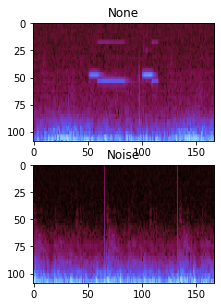

In [ ]:
#Example of tiled sound samples

sample_height = training_clips['none'][0][0].shape[0]
sample_width = training_clips['none'][0][0].shape[1]
print(sample_height)
print(sample_width)
ind = 4

plt.figure(figsize = (10,10))
plt.subplot(4,1,1)
plt.imshow(training_clips['none'][ind][0])
plt.title('None')
plt.subplot(4,1,2)
plt.imshow(training_clips['both'][ind][0])
plt.title('Noise')


### Data Pipeline

In [ ]:
import scipy.signal

#Interleaved sampling between classes
#Used to ensure a balance of classes for the training set
class data_generator():
    #sound_clips = [[none],[crackles],[wheezes],[both]]
    #strides: How far the sampling index for each category is advanced for each step
    def __init__(self, sound_clips, strides, p_info):
        self.clips = sound_clips
        self.strides = strides
        self.lengths = [len(arr) for arr in sound_clips]
        self.p_info = p_info
        
    def n_available_samples(self):
        return int(min(np.divide(self.lengths, self.strides))) * 4
    
    def generate_keras(self, batch_size):
        cursor = [0,0,0,0]
        while True:
            i = 0
            X1, X2, y = [],[],[]
            for _ in range(batch_size):
                cat_length = self.lengths[i]
                cat_clips = self.clips[i]
                cat_stride = self.strides[i]
                cat_advance = np.random.randint(low= 1,high = cat_stride + 1)
                clip = cat_clips[(cursor[i] + cat_advance) % cat_length]
                cursor[i] = (cursor[i] + self.strides[i]) % cat_length #advance cursor
                s = (self.rollFFT(clip))
                X1.append(s[0])
                y.append(s[1])
                p_id = clip[2]
                info = self.p_info[self.p_info['Patient number'] == p_id][['Sex', 'Age']].values	
                X2.append(info)
                i = (i + 1) % 4 # go to next class
            yield ([np.reshape(X1, (batch_size, sample_height, sample_width, 3)) ,np.reshape(X2, (batch_size, 2))],
                   np.reshape(y,(batch_size,4)))

    #Transpose and wrap each array along the time axis
    def rollFFT(self, fft_info):
        fft = fft_info[0]
        n_col = fft.shape[1]
        pivot = np.random.randint(n_col)
        return ((np.roll(fft, pivot, axis = 1)), fft_info[1])

#Used for validation set
class feed_all():
    #sound_clips = [[none],[crackles],[wheezes],[both]]
    #strides: How far the sampling index for each category is advanced for each step
    def __init__(self, sound_clips, p_info, roll = True):
        merged = []
        for arr in sound_clips:
            merged.extend(arr)
        np.random.shuffle(merged)
        self.clips = merged
        self.nclips = len(merged)
        self.roll = roll
        self.p_info = p_info
    
    def n_available_samples(self):
        return len(self.clips)
    
    def generate_keras(self, batch_size):
        i = 0
        while True:
            X1, X2, y = [],[],[]
            for b in range(batch_size):
                clip = self.clips[i]
                i = (i + 1) % self.nclips
                if(self.roll):
                    s = (self.rollFFT(clip))
                    X1.append(s[0])
                    y.append(s[1])
                    p_id = clip[2]
                    info = self.p_info[self.p_info['Patient number'] == p_id][['Sex', 'Age']].values
                    X2.append(info)
                else:
                    X1.append(clip[0])
                    y.append(clip[1])
                    p_id = clip[2]
                    info = self.p_info[self.p_info['Patient number'] == p_id][['Sex', 'Age']].values
                    X2.append(info)
            yield ([np.reshape(X1, (batch_size,sample_height, sample_width,3)), np.reshape(X2, (batch_size, 2))],
                  np.reshape(y,(batch_size, 4)))

    #Transpose and wrap each array along the time axis
    def rollFFT(self, fft_info):
        fft = fft_info[0]
        n_col = fft.shape[1]
        pivot = np.random.randint(n_col)
        return ((np.roll(fft, pivot, axis = 1)), fft_info[1])

In [ ]:
[none_train, c_train, w_train, c_w_train] = [training_clips['none'], training_clips['crackles'], training_clips['wheezes'], training_clips['both']]
[none_test, c_test, w_test,c_w_test] = [test_clips['none'], test_clips['crackles'], test_clips['wheezes'], test_clips['both']]
np.random.shuffle(none_train)
np.random.shuffle(c_train)
np.random.shuffle(w_train)
np.random.shuffle(c_w_train)

#Data pipeline objects
train_gen = data_generator([none_train, c_train, w_train, c_w_train], [1,1,1,1], patient_data)
test_gen = feed_all([none_test, c_test, w_test,c_w_test], patient_data)

In [ ]:
del none_train
del c_train
del w_train
del c_w_train

### CNN implementation

In [ ]:
import keras.layers as layers
from keras import optimizers
from keras import backend as K
K.clear_session()

spect_input = keras.Input(shape=(sample_height, sample_width, 3), name="spec")
pinfo_input = keras.Input(shape=(2,), name="pinfo")

pinfo_features = layers.Dense(128, activation = 'relu')(pinfo_input)
pinfo_features = layers.Dense(128, activation = 'relu')(pinfo_features)
pinfo_features = layers.Dropout(0.5)(pinfo_features)
pinfo_features = layers.Dense(64, activation = 'relu')(pinfo_features)
'''
spect
'''

spect_features = layers.Conv2D(128, [7,11], strides = [2,2], padding = 'SAME')(spect_input)
spect_features = layers.LeakyReLU(alpha = 0.1)(spect_features)
spect_features = layers.MaxPool2D(padding = 'SAME')(spect_features)

spect_features = layers.Conv2D(256, [5,5], padding = 'SAME')(spect_features)
spect_features = layers.LeakyReLU(alpha = 0.1)(spect_features)
spect_features = layers.MaxPool2D(padding = 'SAME')(spect_features)
spect_features = layers.Dropout(0.5)(spect_features)

spect_features = layers.Conv2D(256, [1,1], padding = 'SAME')(spect_features)
spect_features = layers.Conv2D(256, [3,3], padding = 'SAME')(spect_features)
spect_features = layers.LeakyReLU(alpha = 0.1)(spect_features)
spect_features = layers.MaxPool2D(padding = 'SAME')(spect_features)
spect_features = layers.Dropout(0.5)(spect_features)

spect_features = layers.Conv2D(512, [1,1], padding = 'SAME')(spect_features)
spect_features = layers.Conv2D(512, [3,3], padding = 'SAME', activation = 'relu')(spect_features)
spect_features = layers.Conv2D(512, [1,1], padding = 'SAME')(spect_features)
spect_features = layers.Conv2D(512, [3,3], padding = 'SAME', activation = 'relu')(spect_features)
spect_features = layers.MaxPool2D(padding = 'SAME')(spect_features)

# 2*8*512
# spect_features = tf.reshape(spect_features, [-1, 16, 512])
# spect_features = layers.LSTM(256, return_sequences=True)(spect_features)
# spect_features = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(spect_features)

spect_features = layers.Flatten()(spect_features)
spect_features = layers.Dense(4096, activation='relu')(spect_features)
spect_features = layers.Dropout(0.5)(spect_features)
spect_features = layers.Dense(512, activation='relu')(spect_features)


x = layers.concatenate([spect_features, pinfo_features])
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(4, activation='softmax')(x)

model = keras.Model(inputs = [spect_input, pinfo_input],
                    outputs = outputs)

opt = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)
model.compile(optimizer =  opt , loss = 'categorical_crossentropy', metrics = ['acc'])

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names = True)
from IPython.display import Image
Image(filename='model.png')

In [ ]:
batch_size = 128
n_epochs = 20
stats = model.fit(train_gen.generate_keras(batch_size), 
                            steps_per_epoch = train_gen.n_available_samples() // batch_size,
                            validation_data = test_gen.generate_keras(batch_size),
                            validation_steps = test_gen.n_available_samples() // batch_size, 
                            epochs = n_epochs)

Epoch 1/20
189/189 [==============================] - 108s 398ms/step - loss: 1.3263 - acc: 0.3489 - val_loss: 1.2826 - val_acc: 0.3750
Epoch 2/20
189/189 [==============================] - 74s 391ms/step - loss: 1.1827 - acc: 0.4662 - val_loss: 1.2208 - val_acc: 0.4688
Epoch 3/20
189/189 [==============================] - 75s 400ms/step - loss: 1.0767 - acc: 0.5292 - val_loss: 1.1150 - val_acc: 0.4957
Epoch 4/20
189/189 [==============================] - 76s 400ms/step - loss: 0.9859 - acc: 0.5734 - val_loss: 1.0366 - val_acc: 0.5661
Epoch 5/20
189/189 [==============================] - 73s 389ms/step - loss: 0.8970 - acc: 0.6191 - val_loss: 0.9755 - val_acc: 0.5923
Epoch 6/20
189/189 [==============================] - 74s 393ms/step - loss: 0.8038 - acc: 0.6623 - val_loss: 0.9303 - val_acc: 0.6108
Epoch 7/20
189/189 [==============================] - 76s 401ms/step - loss: 0.7391 - acc: 0.6942 - val_loss: 0.9548 - val_acc: 0.6229
Epoch 8/20
189/189 [==============================] - 

In [ ]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(stats.history['acc'], label = 'training acc')
plt.plot(stats.history['val_acc'], label = 'validation acc')
plt.legend()
plt.subplot(1,2,2)
plt.plot(stats.history['loss'], label = 'training loss')
plt.plot(stats.history['val_loss'], label = 'validation loss')
plt.legend()
plt.title('Loss')

In [ ]:
test_set = test_gen.generate_keras(test_gen.n_available_samples()).__next__()
predictions = model.predict(test_set[0])
predictions = np.argmax(predictions, axis = 1)
labels = np.argmax(test_set[1], axis = 1)

In [ ]:
test_set[1].shape

In [ ]:
print(f'{len(test_clips["both"])} + {len(test_clips["crackles"])} + {len(test_clips["wheezes"])}')
print(f'{len(test_clips["both"]) + len(test_clips["crackles"]) + len(test_clips["wheezes"])}')

108 + 376 + 183
667


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(labels, predictions, target_names = ['none','crackles','wheezes','both']))
print(confusion_matrix(labels, predictions))

              precision    recall  f1-score   support

        none       0.82      0.79      0.80       760
    crackles       0.64      0.73      0.68       376
     wheezes       0.65      0.58      0.61       183
        both       0.54      0.53      0.53       108

    accuracy                           0.73      1427
   macro avg       0.66      0.66      0.66      1427
weighted avg       0.73      0.73      0.73      1427

[[599 116  31  14]
 [ 70 274   9  23]
 [ 50  14 107  12]
 [ 12  21  18  57]]


In [ ]:
fname = "0822_2213_img_4model"
model.save('/content/drive/MyDrive/grad_article/models/' + fname)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/grad_article/models/0822_2213_img_4model/assets


## **2class**

### data check

In [ ]:
training_clips = sample_dict[0]
test_clips = sample_dict[1]

In [ ]:
def print_sample_count(src_dict):
    print(f"none:{len(src_dict['none'])}\nnoise:{len(src_dict['noise'])}")

print('Samples Available')
print('[Training set]')
print_sample_count(training_clips)
print('')
print('[Test set]')
print_sample_count(test_clips)

Samples Available
[Training set]
none:6078
noise:5328

[Test set]
none:764
noise:667


In [ ]:
#Example of tiled sound samples

sample_height = training_clips['none'][0][0].shape[0]
sample_width = training_clips['none'][0][0].shape[1]
ind = 4

plt.figure(figsize = (10,10))
plt.subplot(4,1,1)
plt.imshow(training_clips['none'][ind][0].reshape(sample_height, sample_width))
plt.title('None')
plt.subplot(4,1,2)
plt.imshow(training_clips['noise'][ind][0].reshape(sample_height, sample_width))
plt.title('Noise')


### Data Pipeline

In [ ]:
import scipy.signal

#Interleaved sampling between classes
#Used to ensure a balance of classes for the training set
class data_generator():
    #sound_clips = [[none],[crackles],[wheezes],[both]]
    #strides: How far the sampling index for each category is advanced for each step
    def __init__(self, sound_clips, strides):
        self.clips = sound_clips
        self.strides = strides
        self.lengths = [len(arr) for arr in sound_clips]
    
    def n_available_samples(self):
        return int(min(np.divide(self.lengths, self.strides))) * 2#
    
    def generate_keras(self, batch_size):
        cursor = [0, 0] #
        while True:
            i = 0
            X,y = [],[]
            for c in range(batch_size):
                cat_length = self.lengths[i]
                cat_clips = self.clips[i]
                cat_stride = self.strides[i]
                cat_advance = np.random.randint(low= 1,high = cat_stride + 1)
                clip = cat_clips[(cursor[i] + cat_advance) % cat_length]
                cursor[i] = (cursor[i] + self.strides[i]) % cat_length #advance cursor
                s = (self.rollFFT(clip))
                X.append(s[0])
                y.append(s[1])
                i = (i + 1) % 2 # go to next class
            yield (np.reshape(X, (batch_size, sample_height, sample_width, 1)),
                   np.reshape(y,(batch_size,1)))#

    #Transpose and wrap each array along the time axis
    def rollFFT(self, fft_info):
        fft = fft_info[0]
        n_col = fft.shape[1]
        pivot = np.random.randint(n_col)
        return ((np.roll(fft, pivot, axis = 1)), fft_info[1])

#Used for validation set
class feed_all():
    #sound_clips = [[none],[crackles],[wheezes],[both]]
    #strides: How far the sampling index for each category is advanced for each step
    def __init__(self, sound_clips, roll = True):
        merged = []
        for arr in sound_clips:
            merged.extend(arr)
        np.random.shuffle(merged)
        self.clips = merged
        self.nclips = len(merged)
        self.roll = roll
    
    def n_available_samples(self):
        return len(self.clips)
    
    def generate_keras(self, batch_size):
        i = 0
        while True:
            X,y = [],[]
            for b in range(batch_size):
                clip = self.clips[i]
                i = (i + 1) % self.nclips
                if(self.roll):
                    s = (self.rollFFT(clip))
                    X.append(s[0])
                    y.append(s[1])
                else:
                    X.append(clip[0])
                    y.append(clip[1])
                    
            yield (np.reshape(X, (batch_size,sample_height, sample_width,1)),
                   np.reshape(y,(batch_size, 1)))

    #Transpose and wrap each array along the time axis
    def rollFFT(self, fft_info):
        fft = fft_info[0]
        n_col = fft.shape[1]
        pivot = np.random.randint(n_col)
        return ((np.roll(fft, pivot, axis = 1)), fft_info[1])

In [ ]:
training_clips = sample_dict[0]
test_clips = sample_dict[1]
[none_train, noise_train] = [training_clips['none'], training_clips['noise']]
[none_test, noise_test] =  [test_clips['none'], test_clips['noise']]

np.random.shuffle(none_train)
np.random.shuffle(noise_train)

#Data pipeline objects
train_gen = data_generator([none_train, noise_train], [1,1])
test_gen = feed_all([none_test, noise_test])

### CNN implementation

In [ ]:
#Keras implementation
from keras import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Conv2D, Dense, Activation, Dropout, MaxPool2D, Flatten, LeakyReLU
K.clear_session()

model = Sequential()
model.add(Conv2D(128, [7,11], strides = [2,2], padding = 'SAME', input_shape = (sample_height, sample_width, 1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPool2D(padding = 'SAME'))

model.add(Conv2D(256, [5,5], padding = 'SAME'))
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPool2D(padding = 'SAME'))

model.add(Conv2D(256, [1,1], padding = 'SAME'))
model.add(Conv2D(256, [3,3], padding = 'SAME'))
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPool2D(padding = 'SAME'))

model.add(Conv2D(512, [1,1], padding = 'SAME'))
model.add(Conv2D(512, [3,3], padding = 'SAME',activation = 'relu'))
model.add(Conv2D(512, [1,1], padding = 'SAME'))
model.add(Conv2D(512, [3,3], padding = 'SAME', activation = 'relu'))
model.add(MaxPool2D(padding = 'SAME'))
model.add(Flatten())

model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(512, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)

model.compile(optimizer =  opt , loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names = True)
from IPython.display import Image
Image(filename='model.png')

In [ ]:
batch_size = 256
n_epochs = 40
stats = model.fit(train_gen.generate_keras(batch_size), 
                            steps_per_epoch = train_gen.n_available_samples() // batch_size,
                            validation_data = test_gen.generate_keras(batch_size),
                            validation_steps = test_gen.n_available_samples() // batch_size, 
                            epochs = n_epochs)

Epoch 1/40
41/41 [==============================] - 11s 258ms/step - loss: 0.6795 - acc: 0.5776 - val_loss: 0.6568 - val_acc: 0.6164
Epoch 2/40
41/41 [==============================] - 11s 263ms/step - loss: 0.6592 - acc: 0.6150 - val_loss: 0.6445 - val_acc: 0.6320
Epoch 3/40
41/41 [==============================] - 11s 271ms/step - loss: 0.6402 - acc: 0.6407 - val_loss: 0.6308 - val_acc: 0.6531
Epoch 4/40
41/41 [==============================] - 11s 267ms/step - loss: 0.6187 - acc: 0.6614 - val_loss: 0.6148 - val_acc: 0.6562
Epoch 5/40
41/41 [==============================] - 11s 262ms/step - loss: 0.5928 - acc: 0.6896 - val_loss: 0.6168 - val_acc: 0.6445
Epoch 6/40
41/41 [==============================] - 11s 258ms/step - loss: 0.5766 - acc: 0.6994 - val_loss: 0.5953 - val_acc: 0.6844
Epoch 7/40
41/41 [==============================] - 10s 256ms/step - loss: 0.5539 - acc: 0.7122 - val_loss: 0.5938 - val_acc: 0.6812
Epoch 8/40
41/41 [==============================] - 10s 256ms/step - 

In [ ]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(stats.history['acc'], label = 'training acc')
plt.plot(stats.history['val_acc'], label = 'validation acc')
plt.legend()
plt.subplot(1,2,2)
plt.plot(stats.history['loss'], label = 'training loss')
plt.plot(stats.history['val_loss'], label = 'validation loss')
plt.legend()
plt.title('Loss')

In [ ]:
test_set = test_gen.generate_keras(test_gen.n_available_samples()).__next__()
predictions = model.predict(test_set[0])
predictions = np.argmax(predictions, axis = 1)
labels = np.argmax(test_set[1], axis = 1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(labels, predictions, target_names = ['none','crackles','wheezes','both']))
print(confusion_matrix(labels, predictions))

In [ ]:
fname = "0818_2318_model"
model.save('/content/drive/MyDrive/grad_article/models_No_patient/' + fname)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/grad_article/models_No_patient/0818_2318_model/assets


## **4class**

### data check

In [ ]:
def class2_to_class4(class2dict):
  class4dict = class2dict.copy()
  for idx, dicts in enumerate(class4dict):
    crackles = []
    wheezes = []
    both = []
    for e in dicts["noise"]:
      i = e[3]
      if recording_anno.iloc[i]["cr"] == 1:
        crackles.append(e)
      elif recording_anno.iloc[i]["wh"] == 1:
        wheezes.append(e)
      else:
        both.append(e)
    class4dict[idx]["crackles"] = crackles
    class4dict[idx]["wheezes"] = wheezes
    class4dict[idx]["both"] = both
  return class4dict
# 2->4だとデータ数が不均衡だから微妙

In [ ]:
def print_sample_count(src_dict):
    print(f"none:{len(src_dict['none'])}\ncrackles:{len(src_dict['crackles'])}\
    \nwheezes:{len(src_dict['wheezes'])}\nboth:{len(src_dict['both'])}")

# sample_dict = class2_to_class4(sample_dict)
training_clips = sample_dict[0]
test_clips = sample_dict[1]
print('Samples Available')
print('[Training set]')
print_sample_count(training_clips)
print('')
print('[Test set]')
print_sample_count(test_clips)

Samples Available
[Training set]
none:6086
crackles:6048    
wheezes:7280
both:6800

[Test set]
none:760
crackles:376    
wheezes:183
both:108


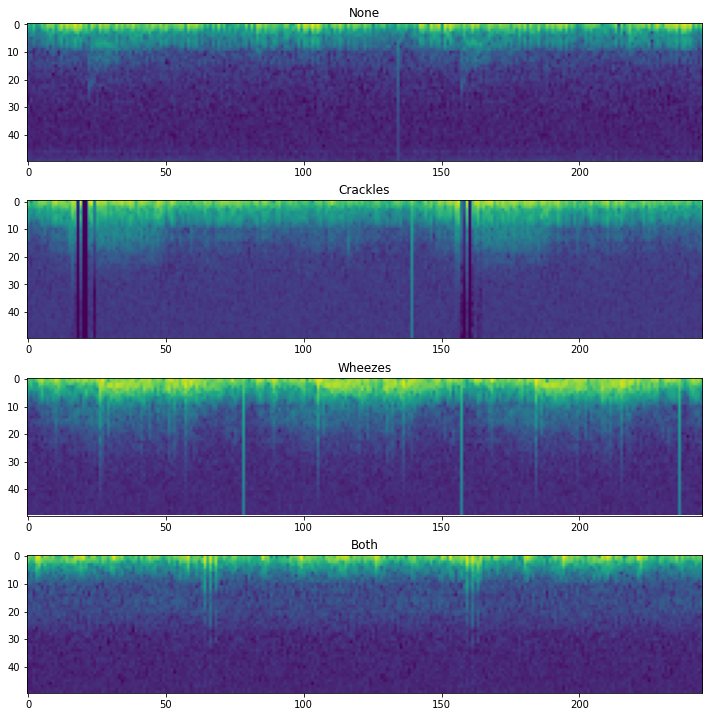

In [ ]:
#Example of tiled sound samples

sample_height = training_clips['none'][0][0].shape[0]
sample_width = training_clips['none'][0][0].shape[1]
ind = 10

plt.figure(figsize = (10,10))
plt.subplot(4,1,1)
plt.imshow(training_clips['none'][ind][0].reshape(sample_height, sample_width))
plt.title('None')
plt.subplot(4,1,2)
plt.imshow(training_clips['crackles'][ind][0].reshape(sample_height, sample_width))
plt.title('Crackles')
plt.subplot(4,1,3)
plt.imshow(training_clips['wheezes'][ind][0].reshape(sample_height, sample_width))
plt.title('Wheezes')
plt.subplot(4,1,4)
plt.imshow(training_clips['both'][ind][0].reshape(sample_height, sample_width))
plt.title('Both')
plt.tight_layout()

### Data Pipeline

In [ ]:
import scipy.signal

#Interleaved sampling between classes
#Used to ensure a balance of classes for the training set
class data_generator():
    #sound_clips = [[none],[crackles],[wheezes],[both]]
    #strides: How far the sampling index for each category is advanced for each step
    def __init__(self, sound_clips, strides):
        self.clips = sound_clips
        self.strides = strides
        self.lengths = [len(arr) for arr in sound_clips]
    
    def n_available_samples(self):
        return int(min(np.divide(self.lengths, self.strides))) * 4
    
    def generate_keras(self, batch_size):
        cursor = [0,0,0,0]
        while True:
            i = 0
            X,y = [],[]
            for c in range(batch_size):
                cat_length = self.lengths[i]
                cat_clips = self.clips[i]
                cat_stride = self.strides[i]
                cat_advance = np.random.randint(low= 1,high = cat_stride + 1)
                clip = cat_clips[(cursor[i] + cat_advance) % cat_length]
                cursor[i] = (cursor[i] + self.strides[i]) % cat_length #advance cursor
                s = (self.rollFFT(clip))
                X.append(s[0])
                y.append(s[1])
                i = (i + 1) % 4 # go to next class
            yield (np.reshape(X, (batch_size, sample_height, sample_width, 1)),
                   np.reshape(y,(batch_size,4)))

    #Transpose and wrap each array along the time axis
    def rollFFT(self, fft_info):
        fft = fft_info[0]
        n_col = fft.shape[1]
        pivot = np.random.randint(n_col)
        return ((np.roll(fft, pivot, axis = 1)), fft_info[1])

#Used for validation set
class feed_all():
    #sound_clips = [[none],[crackles],[wheezes],[both]]
    #strides: How far the sampling index for each category is advanced for each step
    def __init__(self, sound_clips, roll = True):
        merged = []
        for arr in sound_clips:
            merged.extend(arr)
        np.random.shuffle(merged)
        self.clips = merged
        self.nclips = len(merged)
        self.roll = roll
    
    def n_available_samples(self):
        return len(self.clips)
    
    def generate_keras(self, batch_size):
        i = 0
        while True:
            X,y = [],[]
            for b in range(batch_size):
                clip = self.clips[i]
                i = (i + 1) % self.nclips
                if(self.roll):
                    s = (self.rollFFT(clip))
                    X.append(s[0])
                    y.append(s[1])
                else:
                    X.append(clip[0])
                    y.append(clip[1])
                    
            yield (np.reshape(X, (batch_size,sample_height, sample_width,1)),
                   np.reshape(y,(batch_size, 4)))

    #Transpose and wrap each array along the time axis
    def rollFFT(self, fft_info):
        fft = fft_info[0]
        n_col = fft.shape[1]
        pivot = np.random.randint(n_col)
        return ((np.roll(fft, pivot, axis = 1)), fft_info[1])

In [ ]:
training_clips['none'][0][0]

array([[[0.6491921 ],
        [0.81546384],
        [0.89382696],
        ...,
        [0.80440736],
        [0.7410212 ],
        [0.6792282 ]],

       [[0.61008406],
        [0.7545625 ],
        [0.8326246 ],
        ...,
        [0.74296266],
        [0.6875456 ],
        [0.6112982 ]],

       [[0.5462823 ],
        [0.6567959 ],
        [0.7088765 ],
        ...,
        [0.6242497 ],
        [0.5860581 ],
        [0.48916042]],

       ...,

       [[0.03489722],
        [0.0558204 ],
        [0.04990653],
        ...,
        [0.03807903],
        [0.03020277],
        [0.03728703]],

       [[0.04414339],
        [0.04420004],
        [0.05711662],
        ...,
        [0.03971079],
        [0.0419487 ],
        [0.0425017 ]],

       [[0.03744745],
        [0.0403003 ],
        [0.03797605],
        ...,
        [0.04967268],
        [0.04815333],
        [0.03119029]]], dtype=float32)

In [ ]:
[none_train, c_train, w_train, c_w_train] = [training_clips['none'], training_clips['crackles'], training_clips['wheezes'], training_clips['both']]
[none_test, c_test, w_test,c_w_test] =  [test_clips['none'], test_clips['crackles'], test_clips['wheezes'], test_clips['both']]

np.random.shuffle(none_train)
np.random.shuffle(c_train)
np.random.shuffle(w_train)
np.random.shuffle(c_w_train)

#Data pipeline objects
train_gen = data_generator([none_train, c_train, w_train, c_w_train], [1,1,1,1])
test_gen = feed_all([none_test, c_test, w_test,c_w_test])

### CNN implementation

In [ ]:
import keras.layers as layers
from keras import optimizers
from keras import backend as K
K.clear_session()

spect_input = keras.Input(shape=(sample_height, sample_width, 1), name="spec")
spect_features = layers.BatchNormalization(
    axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,
    beta_initializer='zeros', gamma_initializer='ones',
    moving_mean_initializer='zeros',
    moving_variance_initializer='ones',)(spect_input)
spect_features = layers.Conv2D(64, [5,7], padding = 'SAME')(spect_features)
spect_features = layers.MaxPool2D(pool_size=(2, 3), padding = 'SAME')(spect_features)
spect_features = layers.Conv2D(64, [3,3], padding = 'SAME', activation = 'relu')(spect_features)
spect_features = layers.Conv2D(64, [3,3], padding = 'SAME', activation = 'relu')(spect_features)

spect_features = layers.MaxPool2D(pool_size=(2, 3),padding = 'SAME')(spect_features)
spect_features = layers.Conv2D(128, [3,3], padding = 'SAME', activation = 'relu')(spect_features)
spect_features = layers.Conv2D(128, [3,3], padding = 'SAME', activation = 'relu')(spect_features)

spect_features = layers.MaxPool2D(pool_size=(2, 3),padding = 'SAME')(spect_features)
spect_features = layers.Conv2D(128, [3,3], padding = 'SAME', activation = 'relu')(spect_features)
spect_features = layers.Conv2D(128, [3,3], padding = 'SAME', activation = 'relu')(spect_features)

# 7*10*128
spect_features = tf.reshape(spect_features, [-1, 70, 128])
spect_features = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(spect_features)

spect_features = layers.Flatten()(spect_features)
spect_features = layers.Dropout(0.5)(spect_features)
spect_features = layers.Dense(100, activation='relu')(spect_features)
spect_features = layers.Dropout(0.5)(spect_features)

outputs = layers.Dense(4, activation='softmax')(spect_features)

model = keras.Model(inputs = spect_input,
                    outputs = outputs)

opt = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)
model.compile(optimizer =  opt , loss = 'categorical_crossentropy', metrics = ['acc'])


In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names = True)
from IPython.display import Image
Image(filename='model.png')

In [ ]:
batch_size = 128
n_epochs = 15
stats = model.fit(train_gen.generate_keras(batch_size), 
                            steps_per_epoch = train_gen.n_available_samples() // batch_size,
                            validation_data = test_gen.generate_keras(batch_size),
                            validation_steps = test_gen.n_available_samples() // batch_size, 
                            epochs = n_epochs)

Epoch 1/15
189/189 [==============================] - 28s 111ms/step - loss: 1.3157 - acc: 0.3668 - val_loss: 1.2433 - val_acc: 0.4027
Epoch 2/15
189/189 [==============================] - 21s 109ms/step - loss: 1.1829 - acc: 0.4752 - val_loss: 1.1089 - val_acc: 0.5391
Epoch 3/15
189/189 [==============================] - 21s 110ms/step - loss: 1.0850 - acc: 0.5305 - val_loss: 1.0749 - val_acc: 0.5298
Epoch 4/15
189/189 [==============================] - 21s 111ms/step - loss: 1.0045 - acc: 0.5708 - val_loss: 1.0300 - val_acc: 0.5533
Epoch 5/15
189/189 [==============================] - 21s 113ms/step - loss: 0.9162 - acc: 0.6203 - val_loss: 1.0487 - val_acc: 0.5746
Epoch 6/15
189/189 [==============================] - 21s 113ms/step - loss: 0.8315 - acc: 0.6582 - val_loss: 0.9725 - val_acc: 0.6030
Epoch 7/15
189/189 [==============================] - 21s 114ms/step - loss: 0.7570 - acc: 0.6929 - val_loss: 0.9845 - val_acc: 0.5909
Epoch 8/15
189/189 [==============================] - 2

In [ ]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(stats.history['acc'], label = 'training acc')
plt.plot(stats.history['val_acc'], label = 'validation acc')
plt.legend()
plt.subplot(1,2,2)
plt.plot(stats.history['loss'], label = 'training loss')
plt.plot(stats.history['val_loss'], label = 'validation loss')
plt.legend()
plt.title('Loss')

In [ ]:
test_set = test_gen.generate_keras(test_gen.n_available_samples()).__next__()
predictions = model.predict(test_set[0])
predictions = np.argmax(predictions, axis = 1)
labels = np.argmax(test_set[1], axis = 1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(labels, predictions, target_names = ['none','crackles','wheezes','both']))
print(confusion_matrix(labels, predictions))

              precision    recall  f1-score   support

        none       0.74      0.85      0.79       760
    crackles       0.62      0.60      0.61       376
     wheezes       0.59      0.36      0.44       183
        both       0.55      0.38      0.45       108

    accuracy                           0.68      1427
   macro avg       0.62      0.55      0.57      1427
weighted avg       0.67      0.68      0.67      1427

[[644  90  20   6]
 [132 226   8  10]
 [ 85  15  65  18]
 [ 14  36  17  41]]


In [ ]:
conf = confusion_matrix(labels, predictions)
support = [760, 376, 183, 108]
def scoring(conf, sup):
  Se = conf[1][1] + conf[2][2] + conf[3][3]
  Se = Se / (sup[1] + sup[2] + sup[3])
  Sp = conf[0][0] / sup[0]
  Sc = (Se + Sp) / 2
  print(f"Se:{Se:.4} Sp:{Sp:.4} Sc:{Sc:.4}")
scoring(conf, support) 

Se:0.4978 Sp:0.8474 Sc:0.6726


## **GradCam** 

In [ ]:
!wget "https://s3.amazonaws.com/book.keras.io/img/ch5/creative_commons_elephant.jpg"  -O "sample.jpg"

--2021-01-12 14:30:36--  https://s3.amazonaws.com/book.keras.io/img/ch5/creative_commons_elephant.jpg
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.10.230
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.10.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190269 (186K) [image/jpeg]
Saving to: ‘sample.jpg’

sample.jpg          100%[===================>] 185.81K   725KB/s    in 0.3s    

2021-01-12 14:30:37 (725 KB/s) - ‘sample.jpg’ saved [190269/190269]



In [ ]:
import numpy as np
import cv2
#GRAD-CAM 用
from tensorflow.keras import models
import tensorflow as tf
import keras
from google.colab.patches import cv2_imshow

# 画像用
from keras.preprocessing.image import array_to_img, img_to_array, load_img
# モデル読み込み用
from keras.models import load_model
from keras.applications.vgg16 import VGG16

IMAGE_SIZE=(224, 224)

In [ ]:
def grad_cam(input_model, x, layer_name):
    """
    Args: 
        input_model(object): モデルオブジェクト
        x(ndarray): 画像
        layer_name(string): 畳み込み層の名前
    Returns:
        output_image(ndarray): 元の画像に色付けした画像
    """

    # 画像の前処理
    # 読み込む画像が1枚なため、次元を増やしておかないとmode.predictが出来ない
    X = np.expand_dims(x, axis=0)
    preprocessed_input = X.astype('float32') / 255.0    

    grad_model = models.Model([input_model.inputs], [input_model.get_layer(layer_name).output, input_model.output])
    keras.utils.plot_model(grad_model, "gradcam.png", show_shapes=True)

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(preprocessed_input)
        class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]

    # 勾配を計算
    print(conv_outputs.shape)
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')

    # all_grads = gate_f * gate_r * grads
    # all_grads = grads * gate_r
    all_grads = grads

    # 勾配を平均化して、レイヤーの出力に乗じる
    weights = np.mean(all_grads, axis=(0, 1))
    cam = np.dot(output, weights)

    # 画像を元画像と同じ大きさにスケーリング
    cam = cv2.resize(cam, IMAGE_SIZE, cv2.INTER_LINEAR)
    # ReLUの代わり
    cam  = np.maximum(cam, 0)
    # ヒートマップを計算
    heatmap = cam / cam.max()

    # モノクロ画像に疑似的に色をつける
    jet_cam = cv2.applyColorMap(np.uint8(255.0*heatmap), cv2.COLORMAP_JET)
    # RGBに変換
    rgb_cam = cv2.cvtColor(jet_cam, cv2.COLOR_BGR2RGB)
    # もとの画像に合成
    # output_image = np.uint8(rgb_cam / 2 + x / 2)  
    output_image = (np.float32(rgb_cam) + x / 2)  

    return output_image

In [ ]:
image_path = "/content/sample.jpg"

model = VGG16(weights='imagenet')
x = img_to_array(load_img(image_path, target_size=IMAGE_SIZE))

In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
target_layer = 'block5_conv3'
cam = grad_cam(model, x, target_layer)

(1, 14, 14, 512)


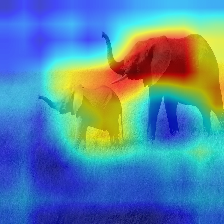

In [ ]:
array_to_img(cam)

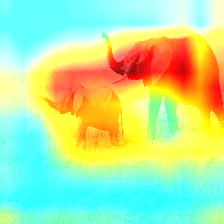

In [ ]:
# cam.max()
cv2_imshow(cv2.cvtColor(cam, cv2.COLOR_RGB2BGR))
# array_to_img(x)

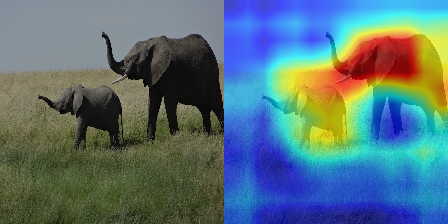

In [ ]:
im_h = cv2.hconcat([x, cam])
array_to_img(im_h)
# cv2.imwrite("/content/concat.png", im_h)
# cat = img_to_array(load_img("/content/concat.png", target_size=IMAGE_SIZE))
# array_to_img(cat)

In [ ]:
x = img_to_array(load_img(image_path, target_size=IMAGE_SIZE))

In [ ]:
img = img_to_array(load_img("/content/gradcam.png", target_size=(2000,500)))
cv2_imshow(img)